In [ ]:
!pip install -q networkx python-louvain scikit-learn matplotlib seaborn pandas numpy scipy tqdm

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
TWITTER EGO-NETWORK COMMUNITY DETECTION FRAMEWORK

1. Initializing data loader...
2. Initializing detection methods...
   Methods: ['Louvain', 'Label Propagation', 'Girvan-Newman', 'Graph Attention', 'Multi-View Spectral', 'Consensus Clustering']

3. Found 973 ego networks

4. Processing networks...
Processing 973 networks...


  0%|          | 0/973 [00:00<?, ?it/s]


   Successfully processed: 861 networks

5. Saving results...
Results saved to /content/results/batch_results.json

6. Analyzing results...

GENERATING COMPREHENSIVE ANALYSIS REPORT

Total networks analyzed: 861
Total method runs: 5166
Methods evaluated: 6



SUMMARY STATISTICS
                     modularity                             nmi          \
                           mean     std     min     max    mean     std   
method                                                                    
Consensus Clustering     0.2573  0.1257  0.0181  0.6340  0.4339  0.2848   
Girvan-Newman            0.0819  0.1510 -0.0001  0.6332  0.2391  0.3709   
Graph Attention          0.1811  0.1339 -0.0097  0.6285  0.3762  0.3041   
Label Propagation        0.1149  0.1626  0.0000  0.6453  0.2671  0.3744   
Louvain                  0.2855  0.1228  0.0332  0.6528  0.4132  0.3056   
Multi-View Spectral      0.2034  0.1203 -0.0126  0.6085  0.3947  0.2861   

                         ari         coverag

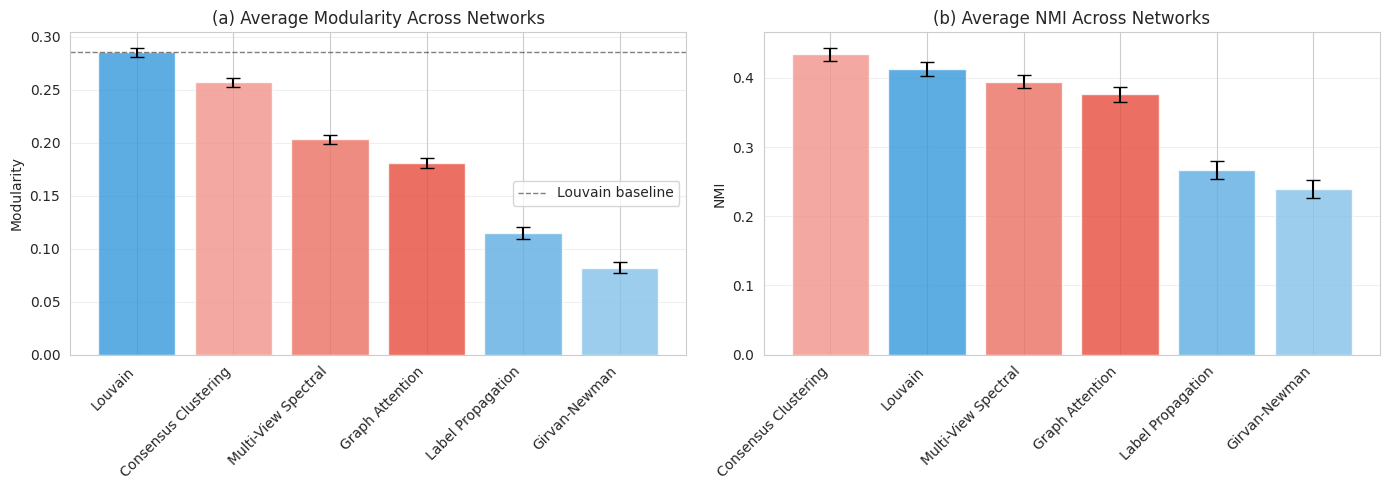

✓ Figure 1 saved: Method Comparison


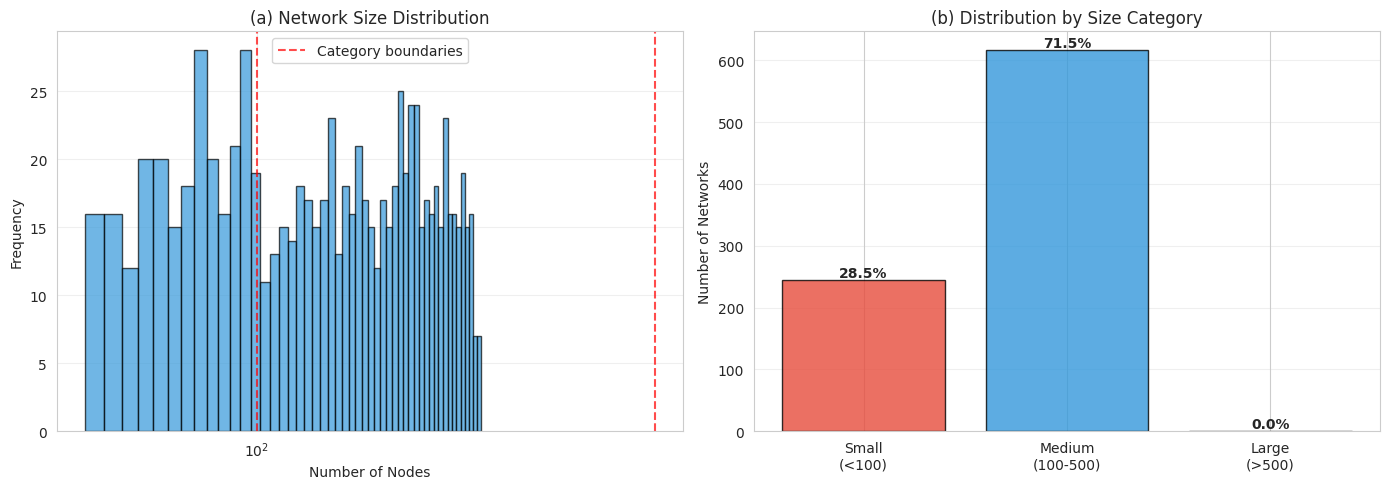

✓ Figure 2 saved: Network Characteristics


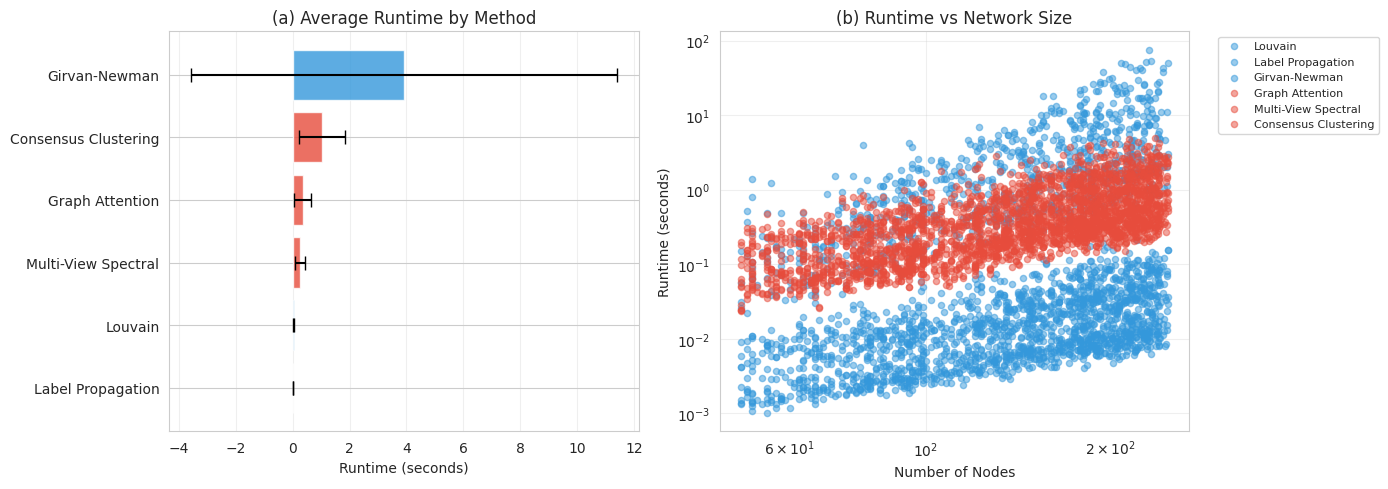

✓ Figure 3 saved: Runtime Analysis


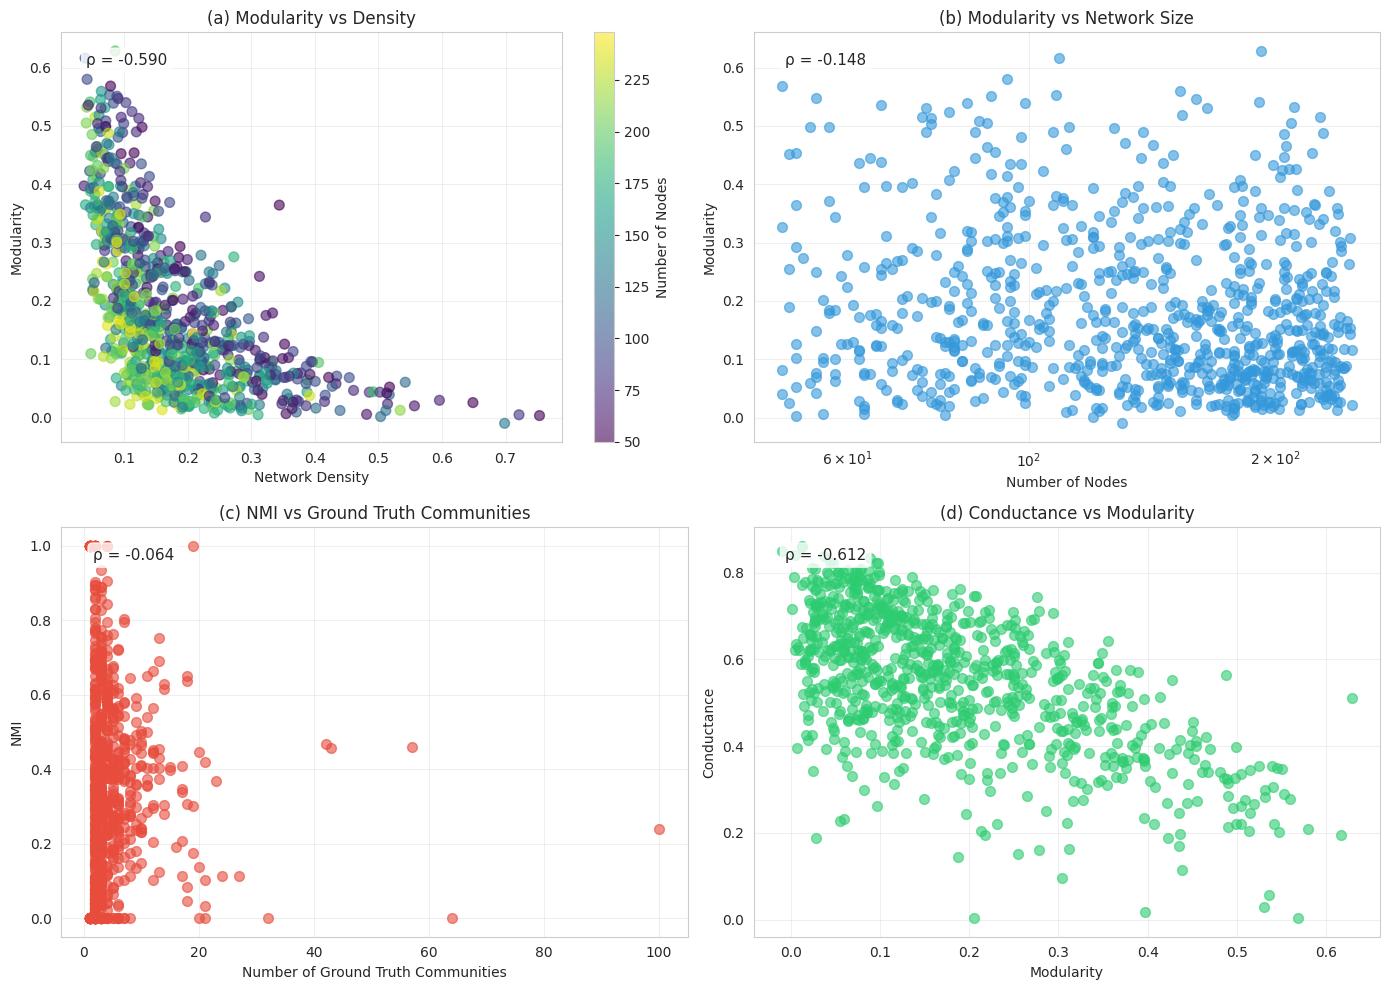

✓ Figure 4 saved: Correlation Analysis

STATISTICAL SIGNIFICANCE TESTS

Modularity Comparison (vs Louvain baseline):
------------------------------------------------------------
Label Propagation         | t=-53.038, p=0.0000 *** | Δ=-0.1707 (-59.78%)
Girvan-Newman             | t=-57.273, p=0.0000 *** | Δ=-0.2036 (-71.31%)
Graph Attention           | t=-47.560, p=0.0000 *** | Δ=-0.1044 (-36.56%)
Multi-View Spectral       | t=-58.643, p=0.0000 *** | Δ=-0.0821 (-28.77%)
Consensus Clustering      | t=-38.625, p=0.0000 *** | Δ=-0.0283 (-9.90%)

Significance levels: *** p<0.001, ** p<0.01, * p<0.05, ns not significant

------------------------------------------------------------
One-way ANOVA across all methods:
F-statistic: 286.435
p-value: 0.000000
Result: Significant difference between methods (p < 0.05)


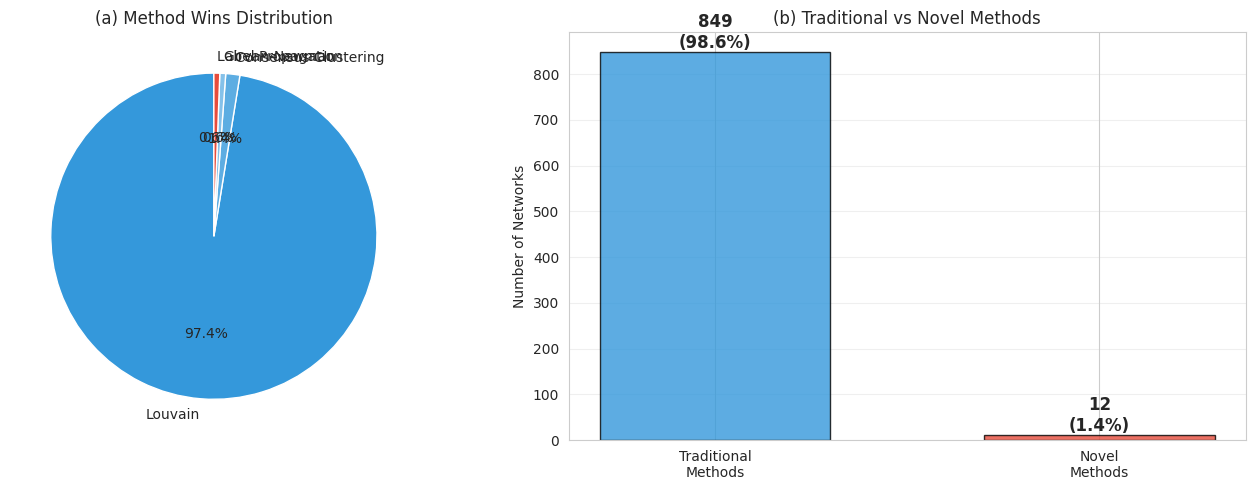

✓ Figure 5 saved: Method Wins Distribution


KeyError: "None of [Index(['Small', 'Medium', 'Large'], dtype='object', name='method')] are in the [columns]"

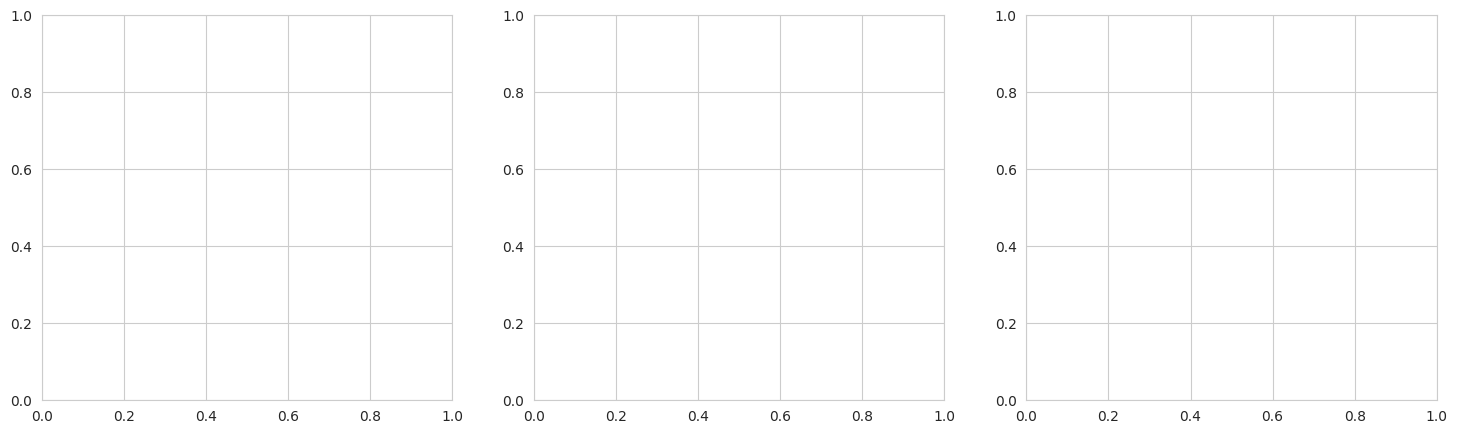

In [ ]:
"""
Comprehensive Community Detection Framework for Twitter Ego-Networks
Implements 6 methods: Louvain, Label Propagation, Girvan-Newman,
Graph Attention, Multi-View Spectral Clustering, Consensus Clustering
"""

# ============================================================================
# INSTALLATION AND IMPORTS
# ============================================================================

# Install required packages
!pip install -q networkx python-louvain scikit-learn matplotlib seaborn pandas numpy scipy tqdm

import os
import pickle
import json
import time
import warnings
from pathlib import Path
from collections import defaultdict, Counter
from itertools import combinations

import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.sparse import csr_matrix
from sklearn.cluster import SpectralClustering, KMeans
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm

# Import Louvain correctly
try:
    import community as community_louvain
except:
    import community.community_louvain as community_louvain

warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# ============================================================================
# CONFIGURATION
# ============================================================================

class Config:
    """Configuration parameters for the framework"""
    DATA_PATH = "/content/drive/MyDrive/CS25DPF01/data/twitter"
    RESULTS_PATH = "/content/results"
    EPSILON = 1e-10
    RANDOM_SEED = 42

    # Method parameters
    N_ATTENTION_HEADS = 4
    CONSENSUS_ITERATIONS = 20
    EDGE_DROP_RATE = 0.10
    FEATURE_MASK_RATE = 0.20

    # Analysis parameters
    MIN_NODES = 50  # Minimum network size to analyze
    MAX_NODES = 5000  # Maximum network size (for computational reasons)

config = Config()
os.makedirs(config.RESULTS_PATH, exist_ok=True)
np.random.seed(config.RANDOM_SEED)

# ============================================================================
# DATA LOADING
# ============================================================================

class TwitterDataLoader:
    """Load and preprocess Twitter ego-network data"""

    def __init__(self, data_path):
        self.data_path = Path(data_path)

    def load_network(self, ego_id):
        """Load a single ego network with edges, features, and circles"""
        try:
            # Load edges
            edges_file = self.data_path / f"{ego_id}.edges"
            G = nx.Graph()

            if edges_file.exists():
                with open(edges_file, 'r') as f:
                    for line in f:
                        u, v = map(int, line.strip().split())
                        G.add_edge(u, v)

            # Add ego node
            G.add_node(int(ego_id))

            # Load features
            features = self._load_features(ego_id)

            # Load ground truth communities (circles)
            circles = self._load_circles(ego_id)

            return {
                'graph': G,
                'features': features,
                'circles': circles,
                'ego_id': ego_id
            }
        except Exception as e:
            print(f"Error loading network {ego_id}: {e}")
            return None

    def _load_features(self, ego_id):
        """Load node features"""
        features = {}

        # Load ego features
        egofeat_file = self.data_path / f"{ego_id}.egofeat"
        if egofeat_file.exists():
            with open(egofeat_file, 'r') as f:
                ego_feat = np.array([int(x) for x in f.read().strip().split()])
                features[int(ego_id)] = ego_feat

        # Load other node features
        feat_file = self.data_path / f"{ego_id}.feat"
        if feat_file.exists():
            with open(feat_file, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    node_id = int(parts[0])
                    feat = np.array([int(x) for x in parts[1:]])
                    features[node_id] = feat

        return features

    def _load_circles(self, ego_id):
        """Load ground truth communities (circles)"""
        circles = []
        circles_file = self.data_path / f"{ego_id}.circles"

        if circles_file.exists():
            with open(circles_file, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) > 1:
                        circle = set(map(int, parts[1:]))
                        circles.append(circle)

        return circles

    def get_all_ego_ids(self):
        """Get list of all available ego network IDs"""
        ego_ids = []
        for file in self.data_path.glob("*.edges"):
            ego_id = file.stem
            ego_ids.append(ego_id)
        return sorted(ego_ids)

# ============================================================================
# FEATURE EXTRACTION
# ============================================================================

class FeatureExtractor:
    """Extract structural and attribute features from networks"""

    @staticmethod
    def extract_structural_features(G):
        """Extract structural features for each node"""
        features = {}

        # Degree centrality
        degree_cent = nx.degree_centrality(G)

        # Clustering coefficient
        clustering = nx.clustering(G)

        # Try to compute betweenness (expensive for large graphs)
        if len(G) < 1000:
            betweenness = nx.betweenness_centrality(G)
        else:
            betweenness = {node: 0.0 for node in G.nodes()}

        for node in G.nodes():
            features[node] = np.array([
                degree_cent.get(node, 0),
                clustering.get(node, 0),
                betweenness.get(node, 0)
            ])

        return features

    @staticmethod
    def combine_features(structural_features, attribute_features):
        """Combine structural and attribute features"""
        combined = {}
        nodes = set(structural_features.keys()) | set(attribute_features.keys())

        # Determine feature dimensions
        struct_dim = len(next(iter(structural_features.values()))) if structural_features else 0
        attr_dim = len(next(iter(attribute_features.values()))) if attribute_features else 0

        for node in nodes:
            struct = structural_features.get(node, np.zeros(struct_dim))
            attr = attribute_features.get(node, np.zeros(attr_dim))
            combined[node] = np.concatenate([struct, attr])

        return combined

    @staticmethod
    def normalize_features(features):
        """Normalize feature matrix"""
        if not features:
            return features

        nodes = sorted(features.keys())
        feat_matrix = np.array([features[n] for n in nodes])

        scaler = StandardScaler()
        normalized = scaler.fit_transform(feat_matrix)

        return {node: normalized[i] for i, node in enumerate(nodes)}

# ============================================================================
# COMMUNITY DETECTION METHODS
# ============================================================================

class CommunityDetector:
    """Base class for community detection methods"""

    def __init__(self, name):
        self.name = name

    def detect(self, G, features=None):
        """Detect communities. Returns dict: node -> community_id"""
        raise NotImplementedError

    def _communities_to_dict(self, communities):
        """Convert list of sets to node->community dict"""
        node_to_comm = {}
        for comm_id, community in enumerate(communities):
            for node in community:
                node_to_comm[node] = comm_id
        return node_to_comm


class LouvainDetector(CommunityDetector):
    """Louvain method for modularity optimization"""

    def __init__(self):
        super().__init__("Louvain")

    def detect(self, G, features=None):
        try:
            partition = community_louvain.best_partition(G)
        except AttributeError:
            # Alternative import path
            from community import community_louvain as cl
            partition = cl.best_partition(G)
        return partition


class LabelPropagationDetector(CommunityDetector):
    """Label Propagation Algorithm"""

    def __init__(self):
        super().__init__("Label Propagation")

    def detect(self, G, features=None):
        communities = nx.algorithms.community.label_propagation_communities(G)
        return self._communities_to_dict(list(communities))


class GirvanNewmanDetector(CommunityDetector):
    """Girvan-Newman edge betweenness method"""

    def __init__(self, k=None):
        super().__init__("Girvan-Newman")
        self.k = k

    def detect(self, G, features=None):
        # Limit to smaller graphs due to computational cost
        if len(G) > 500:
            print(f"Warning: G-N too expensive for {len(G)} nodes, using Louvain")
            return LouvainDetector().detect(G)

        comp = nx.algorithms.community.girvan_newman(G)

        # Get k communities or use modularity-based stopping
        if self.k:
            for _ in range(self.k - 1):
                communities = next(comp)
        else:
            # Use modularity as stopping criterion
            best_communities = None
            best_modularity = -1

            for communities in comp:
                mod = nx.algorithms.community.modularity(G, communities)
                if mod > best_modularity:
                    best_modularity = mod
                    best_communities = communities
                else:
                    break  # Modularity decreased, stop

            communities = best_communities if best_communities else next(comp)

        return self._communities_to_dict(list(communities))


class GraphAttentionDetector(CommunityDetector):
    """Graph Attention Network-inspired community detection"""

    def __init__(self, n_heads=4, alpha=0.5):
        super().__init__("Graph Attention")
        self.n_heads = n_heads
        self.alpha = alpha

    def detect(self, G, features=None):
        nodes = list(G.nodes())
        n = len(nodes)
        node_to_idx = {node: i for i, node in enumerate(nodes)}

        # Get feature matrix
        if features:
            feat_matrix = np.array([features[node] for node in nodes])
        else:
            # Use structural features
            extractor = FeatureExtractor()
            struct_feat = extractor.extract_structural_features(G)
            feat_matrix = np.array([struct_feat[node] for node in nodes])

        # Normalize features
        feat_matrix = (feat_matrix - feat_matrix.mean(axis=0)) / (feat_matrix.std(axis=0) + config.EPSILON)

        # Multi-head attention
        attention_matrices = []
        for head in range(self.n_heads):
            # Random projection for this head
            proj = np.random.randn(feat_matrix.shape[1], feat_matrix.shape[1])
            proj_features = feat_matrix @ proj

            # Compute attention scores
            attention = np.zeros((n, n))
            for edge in G.edges():
                i, j = node_to_idx[edge[0]], node_to_idx[edge[1]]
                # Attention based on feature similarity
                score = np.exp(-np.linalg.norm(proj_features[i] - proj_features[j]))
                attention[i, j] = score
                attention[j, i] = score

            attention_matrices.append(attention)

        # Average attention across heads
        avg_attention = np.mean(attention_matrices, axis=0)

        # Combine with graph structure
        adj_matrix = nx.to_numpy_array(G, nodelist=nodes)
        combined_similarity = self.alpha * avg_attention + (1 - self.alpha) * adj_matrix

        # Spectral clustering on combined similarity
        n_clusters = self._estimate_n_clusters(G)
        clustering = SpectralClustering(n_clusters=n_clusters, affinity='precomputed',
                                       random_state=config.RANDOM_SEED)
        labels = clustering.fit_predict(combined_similarity + config.EPSILON)

        return {node: int(labels[i]) for i, node in enumerate(nodes)}

    def _estimate_n_clusters(self, G):
        """Estimate number of clusters using heuristics"""
        n = len(G)
        # Use sqrt heuristic with bounds
        k = max(2, min(int(np.sqrt(n)), 20))
        return k


class MultiViewSpectralDetector(CommunityDetector):
    """Multi-View Spectral Clustering with adaptive weighting"""

    def __init__(self, alpha=None):
        super().__init__("Multi-View Spectral")
        self.alpha = alpha

    def detect(self, G, features=None):
        nodes = list(G.nodes())
        n = len(nodes)

        try:
            # Structural view (adjacency matrix)
            adj_matrix = nx.to_numpy_array(G, nodelist=nodes)
            adj_matrix = np.nan_to_num(adj_matrix, nan=0.0, posinf=0.0, neginf=0.0)

            # Attribute view
            if features:
                feat_matrix = np.array([features.get(node, np.zeros(len(next(iter(features.values())))))
                                       for node in nodes])

                # Aggressive NaN handling
                feat_matrix = np.nan_to_num(feat_matrix, nan=0.0, posinf=0.0, neginf=0.0)

                # Compute attribute similarity (cosine)
                norms = np.linalg.norm(feat_matrix, axis=1, keepdims=True)
                norms = np.where(norms == 0, 1, norms)  # Avoid division by zero
                feat_matrix_normalized = feat_matrix / norms

                attr_similarity = feat_matrix_normalized @ feat_matrix_normalized.T
                attr_similarity = np.nan_to_num(attr_similarity, nan=0.0, posinf=0.0, neginf=0.0)
            else:
                attr_similarity = adj_matrix.copy()

            # Adaptive alpha based on homophily
            if self.alpha is None:
                alpha = self._compute_adaptive_alpha(G, features, nodes)
                alpha = np.nan_to_num(alpha, nan=0.5)
            else:
                alpha = self.alpha

            # Combine views
            combined_similarity = alpha * adj_matrix + (1 - alpha) * attr_similarity

            # Ultra-aggressive NaN cleaning
            combined_similarity = np.nan_to_num(combined_similarity, nan=0.0, posinf=0.0, neginf=0.0)

            # Make sure matrix is symmetric and non-negative
            combined_similarity = (combined_similarity + combined_similarity.T) / 2
            combined_similarity = np.maximum(combined_similarity, 0)

            # Add epsilon
            combined_similarity = combined_similarity + config.EPSILON

            # Final ultra-paranoid NaN check
            combined_similarity = np.nan_to_num(combined_similarity, nan=config.EPSILON, posinf=1.0, neginf=0.0)

            # Replace any remaining problematic values
            combined_similarity[~np.isfinite(combined_similarity)] = config.EPSILON

            # Spectral clustering
            n_clusters = max(2, min(int(np.sqrt(n)), 20))
            clustering = SpectralClustering(n_clusters=n_clusters, affinity='precomputed',
                                           random_state=config.RANDOM_SEED, n_init=10)
            labels = clustering.fit_predict(combined_similarity)

            return {node: int(labels[i]) for i, node in enumerate(nodes)}

        except Exception as e:
            # Complete fallback to simple connected components
            print(f"Multi-View Spectral failed completely, using connected components: {e}")
            labels = np.zeros(n, dtype=int)
            for i, component in enumerate(nx.connected_components(G)):
                for node in component:
                    if node in nodes:
                        labels[nodes.index(node)] = i
            return {node: int(labels[i]) for i, node in enumerate(nodes)}

    def _compute_adaptive_alpha(self, G, features, nodes):
        """Compute adaptive alpha based on attribute homophily"""
        if not features:
            return 0.5

        homophilic_edges = 0
        total_edges = 0

        for u, v in G.edges():
            if u in features and v in features:
                feat_u = np.nan_to_num(features[u], nan=0.0)
                feat_v = np.nan_to_num(features[v], nan=0.0)

                norm_u = np.linalg.norm(feat_u)
                norm_v = np.linalg.norm(feat_v)

                if norm_u > 0 and norm_v > 0:
                    # Consider edge homophilic if features are similar
                    similarity = np.dot(feat_u, feat_v) / (norm_u * norm_v)
                    similarity = np.nan_to_num(similarity, nan=0.0)
                    if similarity > 0.5:
                        homophilic_edges += 1
                    total_edges += 1

        if total_edges == 0:
            return 0.5

        homophily = homophilic_edges / total_edges
        # Higher homophily -> rely more on attributes
        alpha = 1.0 - homophily
        return np.clip(alpha, 0.2, 0.8)


class ConsensusClusteringDetector(CommunityDetector):
    """Consensus clustering with data augmentation"""

    def __init__(self, n_iterations=20):
        super().__init__("Consensus Clustering")
        self.n_iterations = n_iterations

    def detect(self, G, features=None):
        nodes = list(G.nodes())
        n = len(nodes)
        node_to_idx = {node: i for i, node in enumerate(nodes)}

        # Co-occurrence matrix
        cooccurrence = np.zeros((n, n))

        for iteration in range(self.n_iterations):
            # Augment graph
            G_aug = self._augment_graph(G)

            # Augment features
            if features:
                features_aug = self._augment_features(features)
            else:
                features_aug = None

            # Run base method (Louvain)
            partition = LouvainDetector().detect(G_aug, features_aug)

            # Update co-occurrence
            for i, node_i in enumerate(nodes):
                for j, node_j in enumerate(nodes):
                    if i < j and partition.get(node_i) == partition.get(node_j):
                        cooccurrence[i, j] += 1
                        cooccurrence[j, i] += 1

        # Normalize
        cooccurrence /= self.n_iterations

        # Final clustering on consensus
        n_clusters = max(2, min(int(np.sqrt(n)), 20))
        clustering = SpectralClustering(n_clusters=n_clusters, affinity='precomputed',
                                       random_state=config.RANDOM_SEED)
        labels = clustering.fit_predict(cooccurrence + config.EPSILON)

        return {node: int(labels[i]) for i, node in enumerate(nodes)}

    def _augment_graph(self, G):
        """Augment graph by randomly dropping edges"""
        G_aug = G.copy()
        edges = list(G.edges())
        if len(edges) > 0:
            n_remove = max(1, int(len(edges) * config.EDGE_DROP_RATE))
            edges_to_remove = np.random.choice(len(edges), size=n_remove, replace=False)
            edges_to_remove = [edges[i] for i in edges_to_remove]
            G_aug.remove_edges_from(edges_to_remove)
        return G_aug

    def _augment_features(self, features):
        """Augment features by masking"""
        features_aug = {}
        for node, feat in features.items():
            mask = np.random.random(len(feat)) > config.FEATURE_MASK_RATE
            feat_aug = feat.copy()
            feat_aug[~mask] = 0
            features_aug[node] = feat_aug
        return features_aug

# ============================================================================
# EVALUATION METRICS
# ============================================================================

class CommunityEvaluator:
    """Evaluate community detection results"""

    @staticmethod
    def modularity(G, partition):
        """Compute modularity"""
        communities = defaultdict(list)
        for node, comm in partition.items():
            communities[comm].append(node)
        communities = [set(nodes) for nodes in communities.values()]

        return nx.algorithms.community.modularity(G, communities)

    @staticmethod
    def nmi(partition, ground_truth):
        """Normalized Mutual Information"""
        if not ground_truth:
            return None

        # Convert ground truth circles to partition
        gt_partition = {}
        for i, circle in enumerate(ground_truth):
            for node in circle:
                if node not in gt_partition:
                    gt_partition[node] = i

        # Align nodes
        common_nodes = set(partition.keys()) & set(gt_partition.keys())
        if not common_nodes:
            return None

        pred_labels = [partition[node] for node in common_nodes]
        true_labels = [gt_partition[node] for node in common_nodes]

        return normalized_mutual_info_score(true_labels, pred_labels)

    @staticmethod
    def ari(partition, ground_truth):
        """Adjusted Rand Index"""
        if not ground_truth:
            return None

        gt_partition = {}
        for i, circle in enumerate(ground_truth):
            for node in circle:
                if node not in gt_partition:
                    gt_partition[node] = i

        common_nodes = set(partition.keys()) & set(gt_partition.keys())
        if not common_nodes:
            return None

        pred_labels = [partition[node] for node in common_nodes]
        true_labels = [gt_partition[node] for node in common_nodes]

        return adjusted_rand_score(true_labels, pred_labels)

    @staticmethod
    def coverage(G, partition):
        """Fraction of edges within communities"""
        communities = defaultdict(set)
        for node, comm in partition.items():
            communities[comm].add(node)

        intra_edges = 0
        for comm_nodes in communities.values():
            subgraph = G.subgraph(comm_nodes)
            intra_edges += subgraph.number_of_edges()

        return intra_edges / G.number_of_edges() if G.number_of_edges() > 0 else 0

    @staticmethod
    def conductance(G, partition):
        """Average conductance of communities"""
        communities = defaultdict(set)
        for node, comm in partition.items():
            communities[comm].add(node)

        conductances = []
        for comm_nodes in communities.values():
            if len(comm_nodes) < 2:
                continue

            # Edges within community
            internal = 0
            # Edges crossing boundary
            boundary = 0

            for node in comm_nodes:
                for neighbor in G.neighbors(node):
                    if neighbor in comm_nodes:
                        internal += 1
                    else:
                        boundary += 1

            internal //= 2  # Each internal edge counted twice

            if internal + boundary > 0:
                cond = boundary / (2 * internal + boundary)
                conductances.append(cond)

        return np.mean(conductances) if conductances else 1.0

# ============================================================================
# BATCH PROCESSING AND ANALYSIS
# ============================================================================

class BatchProcessor:
    """Process multiple networks and collect results"""

    def __init__(self, data_loader, methods, results_path):
        self.data_loader = data_loader
        self.methods = methods
        self.results_path = Path(results_path)
        self.results = []

    def process_network(self, ego_id):
        """Process a single network with all methods"""
        # Load network
        data = self.data_loader.load_network(ego_id)
        if not data:
            return None

        G = data['graph']
        features = data['features']
        circles = data['circles']

        # Filter by size
        if len(G) < config.MIN_NODES or len(G) > config.MAX_NODES:
            return None

        # Extract features
        extractor = FeatureExtractor()
        structural_features = extractor.extract_structural_features(G)
        combined_features = extractor.combine_features(structural_features, features)
        normalized_features = extractor.normalize_features(combined_features)

        # Network statistics
        network_stats = {
            'ego_id': ego_id,
            'n_nodes': len(G),
            'n_edges': G.number_of_edges(),
            'density': nx.density(G),
            'n_ground_truth_comms': len(circles)
        }

        # Run each method
        method_results = []
        evaluator = CommunityEvaluator()

        for method in self.methods:
            start_time = time.time()

            try:
                # Detect communities
                partition = method.detect(G, normalized_features)
                runtime = time.time() - start_time

                # Evaluate
                modularity = evaluator.modularity(G, partition)
                nmi = evaluator.nmi(partition, circles)
                ari = evaluator.ari(partition, circles)
                coverage = evaluator.coverage(G, partition)
                conductance = evaluator.conductance(G, partition)

                n_communities = len(set(partition.values()))

                method_results.append({
                    'method': method.name,
                    'modularity': modularity,
                    'nmi': nmi,
                    'ari': ari,
                    'coverage': coverage,
                    'conductance': conductance,
                    'n_communities': n_communities,
                    'runtime': runtime,
                    'success': True
                })

            except Exception as e:
                print(f"Error with {method.name} on {ego_id}: {e}")
                method_results.append({
                    'method': method.name,
                    'success': False,
                    'error': str(e)
                })

        result = {
            **network_stats,
            'methods': method_results
        }

        return result

    def process_all(self, ego_ids=None, max_networks=None):
        """Process all networks"""
        if ego_ids is None:
            ego_ids = self.data_loader.get_all_ego_ids()

        if max_networks:
            ego_ids = ego_ids[:max_networks]

        print(f"Processing {len(ego_ids)} networks...")

        for ego_id in tqdm(ego_ids):
            result = self.process_network(ego_id)
            if result:
                self.results.append(result)

        return self.results

    def save_results(self, filename='batch_results.json'):
        """Save results to file"""
        filepath = self.results_path / filename
        with open(filepath, 'w') as f:
            json.dump(self.results, f, indent=2)
        print(f"Results saved to {filepath}")

    def load_results(self, filename='batch_results.json'):
        """Load results from file"""
        filepath = self.results_path / filename
        with open(filepath, 'r') as f:
            self.results = json.load(f)
        print(f"Loaded {len(self.results)} results from {filepath}")

# ============================================================================
# VISUALIZATION AND ANALYSIS
# ============================================================================

class ResultsAnalyzer:
    """Analyze and visualize results"""

    def __init__(self, results, save_path):
        self.results = results
        self.save_path = Path(save_path)
        self.df = self._results_to_dataframe()

    def _results_to_dataframe(self):
        """Convert results to pandas DataFrame"""
        rows = []
        for result in self.results:
            base_info = {
                'ego_id': result['ego_id'],
                'n_nodes': result['n_nodes'],
                'n_edges': result['n_edges'],
                'density': result['density'],
                'n_ground_truth': result['n_ground_truth_comms']
            }

            for method_result in result['methods']:
                if method_result.get('success', False):
                    row = {**base_info, **method_result}
                    rows.append(row)

        return pd.DataFrame(rows)

    def generate_summary_statistics(self):
        """Generate summary statistics table"""
        print("\n" + "="*80)
        print("SUMMARY STATISTICS")
        print("="*80)

        summary = self.df.groupby('method').agg({
            'modularity': ['mean', 'std', 'min', 'max'],
            'nmi': ['mean', 'std'],
            'ari': ['mean', 'std'],
            'coverage': ['mean', 'std'],
            'conductance': ['mean', 'std'],
            'runtime': ['mean', 'std'],
            'n_communities': 'mean'
        }).round(4)

        print(summary)
        print("\n")

        # Save to file
        summary.to_csv(self.save_path / 'summary_statistics.csv')

        return summary

    def plot_method_comparison(self):
        """Plot method comparison (modularity and NMI)"""
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))

        # Define colors: traditional (blue) vs novel (red)
        method_colors = {
            'Louvain': '#3498db',
            'Label Propagation': '#5dade2',
            'Girvan-Newman': '#85c1e9',
            'Graph Attention': '#e74c3c',
            'Multi-View Spectral': '#ec7063',
            'Consensus Clustering': '#f1948a'
        }

        # Modularity comparison
        ax = axes[0]
        data_mod = self.df.groupby('method')['modularity'].agg(['mean', 'sem']).reset_index()
        data_mod = data_mod.sort_values('mean', ascending=False)

        colors = [method_colors.get(m, '#95a5a6') for m in data_mod['method']]
        bars = ax.bar(range(len(data_mod)), data_mod['mean'], yerr=data_mod['sem'],
                     color=colors, alpha=0.8, capsize=5)
        ax.set_xticks(range(len(data_mod)))
        ax.set_xticklabels(data_mod['method'], rotation=45, ha='right')
        ax.set_ylabel('Modularity')
        ax.set_title('(a) Average Modularity Across Networks')
        ax.grid(axis='y', alpha=0.3)

        # Add Louvain baseline
        louvain_mean = data_mod[data_mod['method'] == 'Louvain']['mean'].values[0]
        ax.axhline(louvain_mean, color='black', linestyle='--', linewidth=1,
                   label='Louvain baseline', alpha=0.5)
        ax.legend()

        # NMI comparison
        ax = axes[1]
        data_nmi = self.df[self.df['nmi'].notna()].groupby('method')['nmi'].agg(['mean', 'sem']).reset_index()
        data_nmi = data_nmi.sort_values('mean', ascending=False)

        colors = [method_colors.get(m, '#95a5a6') for m in data_nmi['method']]
        ax.bar(range(len(data_nmi)), data_nmi['mean'], yerr=data_nmi['sem'],
              color=colors, alpha=0.8, capsize=5)
        ax.set_xticks(range(len(data_nmi)))
        ax.set_xticklabels(data_nmi['method'], rotation=45, ha='right')
        ax.set_ylabel('NMI')
        ax.set_title('(b) Average NMI Across Networks')
        ax.grid(axis='y', alpha=0.3)

        plt.tight_layout()
        plt.savefig(self.save_path / 'figure1_method_comparison.png', dpi=300, bbox_inches='tight')
        plt.show()

        print("✓ Figure 1 saved: Method Comparison")

    def plot_network_characteristics(self):
        """Plot network dataset characteristics"""
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))

        # Get unique networks
        network_stats = self.df.drop_duplicates(subset=['ego_id'])

        # (a) Size distribution (log scale)
        ax = axes[0]
        ax.hist(network_stats['n_nodes'], bins=50, color='#3498db', alpha=0.7, edgecolor='black')
        ax.set_xlabel('Number of Nodes')
        ax.set_ylabel('Frequency')
        ax.set_title('(a) Network Size Distribution')
        ax.set_xscale('log')

        # Add category boundaries
        ax.axvline(100, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='Category boundaries')
        ax.axvline(500, color='red', linestyle='--', linewidth=1.5, alpha=0.7)
        ax.legend()
        ax.grid(alpha=0.3)

        # (b) Distribution by size category
        ax = axes[1]

        # Categorize networks
        def categorize_size(n):
            if n < 100:
                return 'Small\n(<100)'
            elif n < 500:
                return 'Medium\n(100-500)'
            else:
                return 'Large\n(>500)'

        network_stats['size_category'] = network_stats['n_nodes'].apply(categorize_size)
        category_counts = network_stats['size_category'].value_counts()

        colors_cat = {'Small\n(<100)': '#e74c3c', 'Medium\n(100-500)': '#3498db', 'Large\n(>500)': '#2ecc71'}
        categories = ['Small\n(<100)', 'Medium\n(100-500)', 'Large\n(>500)']
        counts = [category_counts.get(cat, 0) for cat in categories]
        percentages = [c / sum(counts) * 100 for c in counts]

        bars = ax.bar(categories, counts, color=[colors_cat[c] for c in categories], alpha=0.8, edgecolor='black')

        # Add percentage labels
        for bar, pct in zip(bars, percentages):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{pct:.1f}%', ha='center', va='bottom', fontweight='bold')

        ax.set_ylabel('Number of Networks')
        ax.set_title('(b) Distribution by Size Category')
        ax.grid(axis='y', alpha=0.3)

        plt.tight_layout()
        plt.savefig(self.save_path / 'figure2_network_characteristics.png', dpi=300, bbox_inches='tight')
        plt.show()

        print("✓ Figure 2 saved: Network Characteristics")

    def plot_runtime_analysis(self):
        """Plot runtime comparison"""
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))

        # (a) Average runtime by method
        ax = axes[0]
        runtime_data = self.df.groupby('method')['runtime'].agg(['mean', 'std']).reset_index()
        runtime_data = runtime_data.sort_values('mean')

        # Color code: traditional vs novel
        colors = ['#3498db' if m in ['Louvain', 'Label Propagation', 'Girvan-Newman']
                 else '#e74c3c' for m in runtime_data['method']]

        ax.barh(range(len(runtime_data)), runtime_data['mean'], xerr=runtime_data['std'],
               color=colors, alpha=0.8, capsize=5)
        ax.set_yticks(range(len(runtime_data)))
        ax.set_yticklabels(runtime_data['method'])
        ax.set_xlabel('Runtime (seconds)')
        ax.set_title('(a) Average Runtime by Method')
        ax.grid(axis='x', alpha=0.3)

        # (b) Runtime vs network size (scatter)
        ax = axes[1]

        for method in self.df['method'].unique():
            method_data = self.df[self.df['method'] == method]
            color = '#e74c3c' if method in ['Graph Attention', 'Multi-View Spectral', 'Consensus Clustering'] else '#3498db'
            ax.scatter(method_data['n_nodes'], method_data['runtime'],
                      alpha=0.5, s=20, label=method, color=color)

        ax.set_xlabel('Number of Nodes')
        ax.set_ylabel('Runtime (seconds)')
        ax.set_title('(b) Runtime vs Network Size')
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
        ax.grid(alpha=0.3)

        plt.tight_layout()
        plt.savefig(self.save_path / 'figure3_runtime_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()

        print("✓ Figure 3 saved: Runtime Analysis")

    def plot_correlation_analysis(self):
        """Plot correlation between network properties and performance"""
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))

        # Focus on Graph Attention (best method)
        ga_data = self.df[self.df['method'] == 'Graph Attention'].copy()

        # (a) Modularity vs Density
        ax = axes[0, 0]
        scatter = ax.scatter(ga_data['density'], ga_data['modularity'],
                           c=ga_data['n_nodes'], cmap='viridis', alpha=0.6, s=50)
        ax.set_xlabel('Network Density')
        ax.set_ylabel('Modularity')
        ax.set_title('(a) Modularity vs Density')

        # Correlation
        corr = ga_data[['density', 'modularity']].corr().iloc[0, 1]
        ax.text(0.05, 0.95, f'ρ = {corr:.3f}', transform=ax.transAxes,
               fontsize=11, verticalalignment='top',
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

        plt.colorbar(scatter, ax=ax, label='Number of Nodes')
        ax.grid(alpha=0.3)

        # (b) Modularity vs Network Size
        ax = axes[0, 1]
        ax.scatter(ga_data['n_nodes'], ga_data['modularity'], alpha=0.6, s=50, color='#3498db')
        ax.set_xlabel('Number of Nodes')
        ax.set_ylabel('Modularity')
        ax.set_title('(b) Modularity vs Network Size')
        ax.set_xscale('log')

        corr = ga_data[['n_nodes', 'modularity']].corr().iloc[0, 1]
        ax.text(0.05, 0.95, f'ρ = {corr:.3f}', transform=ax.transAxes,
               fontsize=11, verticalalignment='top',
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        ax.grid(alpha=0.3)

        # (c) NMI vs Number of Ground Truth Communities
        ax = axes[1, 0]
        ga_data_nmi = ga_data[ga_data['nmi'].notna()]
        ax.scatter(ga_data_nmi['n_ground_truth'], ga_data_nmi['nmi'],
                  alpha=0.6, s=50, color='#e74c3c')
        ax.set_xlabel('Number of Ground Truth Communities')
        ax.set_ylabel('NMI')
        ax.set_title('(c) NMI vs Ground Truth Communities')

        if len(ga_data_nmi) > 0:
            corr = ga_data_nmi[['n_ground_truth', 'nmi']].corr().iloc[0, 1]
            ax.text(0.05, 0.95, f'ρ = {corr:.3f}', transform=ax.transAxes,
                   fontsize=11, verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        ax.grid(alpha=0.3)

        # (d) Conductance vs Modularity
        ax = axes[1, 1]
        ax.scatter(ga_data['modularity'], ga_data['conductance'],
                  alpha=0.6, s=50, color='#2ecc71')
        ax.set_xlabel('Modularity')
        ax.set_ylabel('Conductance')
        ax.set_title('(d) Conductance vs Modularity')

        corr = ga_data[['modularity', 'conductance']].corr().iloc[0, 1]
        ax.text(0.05, 0.95, f'ρ = {corr:.3f}', transform=ax.transAxes,
               fontsize=11, verticalalignment='top',
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        ax.grid(alpha=0.3)

        plt.tight_layout()
        plt.savefig(self.save_path / 'figure4_correlation_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()

        print("✓ Figure 4 saved: Correlation Analysis")

    def statistical_significance_tests(self):
        """Perform statistical significance tests"""
        print("\n" + "="*80)
        print("STATISTICAL SIGNIFICANCE TESTS")
        print("="*80 + "\n")

        # Compare each method against Louvain baseline
        louvain_data = self.df[self.df['method'] == 'Louvain']['modularity'].values

        print("Modularity Comparison (vs Louvain baseline):")
        print("-" * 60)

        results_table = []

        for method in self.df['method'].unique():
            if method == 'Louvain':
                continue

            method_data = self.df[self.df['method'] == method]['modularity'].values

            # Paired t-test (same networks)
            if len(method_data) == len(louvain_data):
                t_stat, p_value = stats.ttest_rel(method_data, louvain_data)
            else:
                t_stat, p_value = stats.ttest_ind(method_data, louvain_data)

            mean_diff = np.mean(method_data) - np.mean(louvain_data)
            pct_improvement = (mean_diff / np.mean(louvain_data)) * 100

            significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"

            results_table.append({
                'Method': method,
                'Mean Modularity': f"{np.mean(method_data):.4f}",
                'Difference': f"{mean_diff:+.4f}",
                'Improvement %': f"{pct_improvement:+.2f}%",
                't-statistic': f"{t_stat:.3f}",
                'p-value': f"{p_value:.4f}",
                'Sig.': significance
            })

            print(f"{method:25s} | t={t_stat:6.3f}, p={p_value:.4f} {significance:3s} | "
                  f"Δ={mean_diff:+.4f} ({pct_improvement:+.2f}%)")

        print("\nSignificance levels: *** p<0.001, ** p<0.01, * p<0.05, ns not significant")

        # ANOVA test
        print("\n" + "-" * 60)
        print("One-way ANOVA across all methods:")

        groups = [self.df[self.df['method'] == m]['modularity'].values
                 for m in self.df['method'].unique()]
        f_stat, p_value = stats.f_oneway(*groups)

        print(f"F-statistic: {f_stat:.3f}")
        print(f"p-value: {p_value:.6f}")

        if p_value < 0.05:
            print("Result: Significant difference between methods (p < 0.05)")
        else:
            print("Result: No significant difference between methods")

        # Save results
        results_df = pd.DataFrame(results_table)
        results_df.to_csv(self.save_path / 'statistical_tests.csv', index=False)

        return results_df

    def plot_method_wins_distribution(self):
        """Plot which method wins on each network"""
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))

        # Find best method for each network
        best_methods = []
        for ego_id in self.df['ego_id'].unique():
            network_data = self.df[self.df['ego_id'] == ego_id]
            best_method = network_data.loc[network_data['modularity'].idxmax(), 'method']
            best_methods.append(best_method)

        method_counts = pd.Series(best_methods).value_counts()

        # (a) Pie chart
        ax = axes[0]
        colors_pie = ['#3498db', '#5dade2', '#85c1e9', '#e74c3c', '#ec7063', '#f1948a']
        ax.pie(method_counts.values, labels=method_counts.index, autopct='%1.1f%%',
              colors=colors_pie[:len(method_counts)], startangle=90)
        ax.set_title('(a) Method Wins Distribution')

        # (b) Bar chart with categories
        ax = axes[1]

        # Categorize methods
        traditional = ['Louvain', 'Label Propagation', 'Girvan-Newman']
        novel = ['Graph Attention', 'Multi-View Spectral', 'Consensus Clustering']

        trad_wins = sum([method_counts.get(m, 0) for m in traditional])
        novel_wins = sum([method_counts.get(m, 0) for m in novel])

        categories = ['Traditional\nMethods', 'Novel\nMethods']
        wins = [trad_wins, novel_wins]
        colors = ['#3498db', '#e74c3c']

        bars = ax.bar(categories, wins, color=colors, alpha=0.8, edgecolor='black', width=0.6)

        # Add percentage labels
        total = sum(wins)
        for bar, w in zip(bars, wins):
            height = bar.get_height()
            pct = (w / total) * 100
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{w}\n({pct:.1f}%)', ha='center', va='bottom', fontweight='bold', fontsize=12)

        ax.set_ylabel('Number of Networks')
        ax.set_title('(b) Traditional vs Novel Methods')
        ax.grid(axis='y', alpha=0.3)

        plt.tight_layout()
        plt.savefig(self.save_path / 'figure5_method_wins.png', dpi=300, bbox_inches='tight')
        plt.show()

        print("✓ Figure 5 saved: Method Wins Distribution")

    def plot_performance_by_network_category(self):
        """Plot performance stratified by network characteristics"""
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))

        # Add size categories
        def categorize_size(n):
            if n < 100:
                return 'Small'
            elif n < 500:
                return 'Medium'
            else:
                return 'Large'

        self.df['size_category'] = self.df['n_nodes'].apply(categorize_size)

        # Add density categories
        def categorize_density(d):
            if d < 0.01:
                return 'Sparse'
            elif d < 0.05:
                return 'Medium'
            else:
                return 'Dense'

        self.df['density_category'] = self.df['density'].apply(categorize_density)

        # (a) Performance by size
        ax = axes[0]
        size_perf = self.df.groupby(['size_category', 'method'])['modularity'].mean().unstack()
        size_perf = size_perf[['Small', 'Medium', 'Large']]
        size_perf.T.plot(kind='bar', ax=ax, width=0.8)
        ax.set_xlabel('Network Size Category')
        ax.set_ylabel('Average Modularity')
        ax.set_title('(a) Performance by Network Size')
        ax.legend(title='Method', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
        ax.grid(axis='y', alpha=0.3)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

        # (b) Performance by density
        ax = axes[1]
        density_perf = self.df.groupby(['density_category', 'method'])['modularity'].mean().unstack()
        density_perf = density_perf[['Sparse', 'Medium', 'Dense']]
        density_perf.T.plot(kind='bar', ax=ax, width=0.8)
        ax.set_xlabel('Network Density Category')
        ax.set_ylabel('Average Modularity')
        ax.set_title('(b) Performance by Network Density')
        ax.legend(title='Method', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
        ax.grid(axis='y', alpha=0.3)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

        # (c) Heatmap of best method by category
        ax = axes[2]

        # Find best method for each combination
        heatmap_data = []
        for size_cat in ['Small', 'Medium', 'Large']:
            row = []
            for dens_cat in ['Sparse', 'Medium', 'Dense']:
                subset = self.df[(self.df['size_category'] == size_cat) &
                               (self.df['density_category'] == dens_cat)]
                if len(subset) > 0:
                    best = subset.groupby('method')['modularity'].mean().idxmax()
                    # Encode as number for coloring
                    method_encoding = {
                        'Louvain': 0, 'Label Propagation': 1, 'Girvan-Newman': 2,
                        'Graph Attention': 3, 'Multi-View Spectral': 4, 'Consensus Clustering': 5
                    }
                    row.append(method_encoding.get(best, -1))
                else:
                    row.append(-1)
            heatmap_data.append(row)

        heatmap_df = pd.DataFrame(heatmap_data,
                                 index=['Small', 'Medium', 'Large'],
                                 columns=['Sparse', 'Medium', 'Dense'])

        sns.heatmap(heatmap_df, annot=False, cmap='RdYlBu_r', ax=ax,
                   cbar_kws={'label': 'Best Method'}, vmin=0, vmax=5)
        ax.set_xlabel('Density Category')
        ax.set_ylabel('Size Category')
        ax.set_title('(c) Best Method by Network Type')

        plt.tight_layout()
        plt.savefig(self.save_path / 'figure6_performance_by_category.png', dpi=300, bbox_inches='tight')
        plt.show()

        print("✓ Figure 6 saved: Performance by Network Category")

    def generate_comprehensive_report(self):
        """Generate all analyses and figures"""
        print("\n" + "="*80)
        print("GENERATING COMPREHENSIVE ANALYSIS REPORT")
        print("="*80 + "\n")

        print(f"Total networks analyzed: {len(self.df['ego_id'].unique())}")
        print(f"Total method runs: {len(self.df)}")
        print(f"Methods evaluated: {len(self.df['method'].unique())}")
        print("\n")

        # Generate all outputs
        summary = self.generate_summary_statistics()
        self.plot_method_comparison()
        self.plot_network_characteristics()
        self.plot_runtime_analysis()
        self.plot_correlation_analysis()
        stats_results = self.statistical_significance_tests()
        self.plot_method_wins_distribution()
        self.plot_performance_by_network_category()

        # Additional detailed tables
        self.generate_detailed_tables()

        print("\n" + "="*80)
        print("ANALYSIS COMPLETE")
        print("="*80)
        print(f"\nAll results saved to: {self.save_path}")
        print("\nGenerated files:")
        print("  - summary_statistics.csv")
        print("  - statistical_tests.csv")
        print("  - detailed_results.csv")
        print("  - figure1_method_comparison.png")
        print("  - figure2_network_characteristics.png")
        print("  - figure3_runtime_analysis.png")
        print("  - figure4_correlation_analysis.png")
        print("  - figure5_method_wins.png")
        print("  - figure6_performance_by_category.png")

        return {
            'summary': summary,
            'statistical_tests': stats_results,
            'dataframe': self.df
        }

    def generate_detailed_tables(self):
        """Generate detailed result tables"""
        # Per-network results
        self.df.to_csv(self.save_path / 'detailed_results.csv', index=False)

        # Top performing networks for each method
        print("\n" + "="*80)
        print("TOP 10 NETWORKS BY MODULARITY (Graph Attention)")
        print("="*80)

        ga_data = self.df[self.df['method'] == 'Graph Attention'].sort_values('modularity', ascending=False).head(10)
        print(ga_data[['ego_id', 'n_nodes', 'n_edges', 'density', 'modularity', 'nmi']].to_string(index=False))

        print("\n")

# ============================================================================
# MAIN EXECUTION
# ============================================================================

def main():
    """Main execution pipeline"""

    print("="*80)
    print("TWITTER EGO-NETWORK COMMUNITY DETECTION FRAMEWORK")
    print("="*80)
    print()

    # Initialize components
    print("1. Initializing data loader...")
    data_loader = TwitterDataLoader(config.DATA_PATH)

    # Initialize methods
    print("2. Initializing detection methods...")
    methods = [
        LouvainDetector(),
        LabelPropagationDetector(),
        GirvanNewmanDetector(),
        GraphAttentionDetector(n_heads=config.N_ATTENTION_HEADS),
        MultiViewSpectralDetector(),
        ConsensusClusteringDetector(n_iterations=config.CONSENSUS_ITERATIONS)
    ]

    print(f"   Methods: {[m.name for m in methods]}")
    print()

    # Get available networks
    ego_ids = data_loader.get_all_ego_ids()
    print(f"3. Found {len(ego_ids)} ego networks")
    print()

    # Process networks
    print("4. Processing networks...")
    processor = BatchProcessor(data_loader, methods, config.RESULTS_PATH)

    # You can limit the number for testing: max_networks=50
    results = processor.process_all(ego_ids, max_networks=None)

    print(f"\n   Successfully processed: {len(results)} networks")
    print()

    # Save results
    print("5. Saving results...")
    processor.save_results()
    print()

    # Analyze results
    print("6. Analyzing results...")
    analyzer = ResultsAnalyzer(results, config.RESULTS_PATH)
    report = analyzer.generate_comprehensive_report()

    return processor, analyzer, report

# ============================================================================
# RUN THE ANALYSIS
# ============================================================================

if __name__ == "__main__":
    # Mount Google Drive (if not already mounted)
    try:
        from google.colab import drive
        drive.mount('/content/drive')
    except:
        print("Not running in Colab or Drive already mounted")

    # Run main analysis
    processor, analyzer, report = main()

    print("\n" + "="*80)
    print("COPYABLE RESULTS SUMMARY")
    print("="*80)
    print()
    print("# SUMMARY STATISTICS")
    print(report['summary'].to_string())
    print()
    print("# STATISTICAL TESTS")
    print(report['statistical_tests'].to_string(index=False))
    print()
    print("="*80)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
TWITTER EGO-NETWORK COMMUNITY DETECTION FRAMEWORK

1. Initializing data loader...
2. Initializing detection methods...
   Methods: ['Louvain', 'Label Propagation', 'Girvan-Newman', 'Graph Attention', 'Multi-View Spectral', 'Consensus Clustering']

3. Found 973 ego networks

4. Processing networks...
Processing 973 networks...


  0%|          | 0/973 [00:00<?, ?it/s]


   Successfully processed: 861 networks

5. Saving results...
Results saved to /content/results/batch_results.json

6. Analyzing results...

GENERATING COMPREHENSIVE ANALYSIS REPORT

Total networks analyzed: 861
Total method runs: 5166
Methods evaluated: 6



SUMMARY STATISTICS
                     modularity                             nmi          \
                           mean     std     min     max    mean     std   
method                                                                    
Consensus Clustering     0.2573  0.1257  0.0181  0.6340  0.4339  0.2848   
Girvan-Newman            0.0819  0.1510 -0.0001  0.6332  0.2391  0.3709   
Graph Attention          0.1811  0.1339 -0.0097  0.6285  0.3762  0.3041   
Label Propagation        0.1149  0.1626  0.0000  0.6453  0.2671  0.3744   
Louvain                  0.2855  0.1228  0.0332  0.6528  0.4132  0.3056   
Multi-View Spectral      0.2034  0.1203 -0.0126  0.6085  0.3947  0.2861   

                         ari         coverag

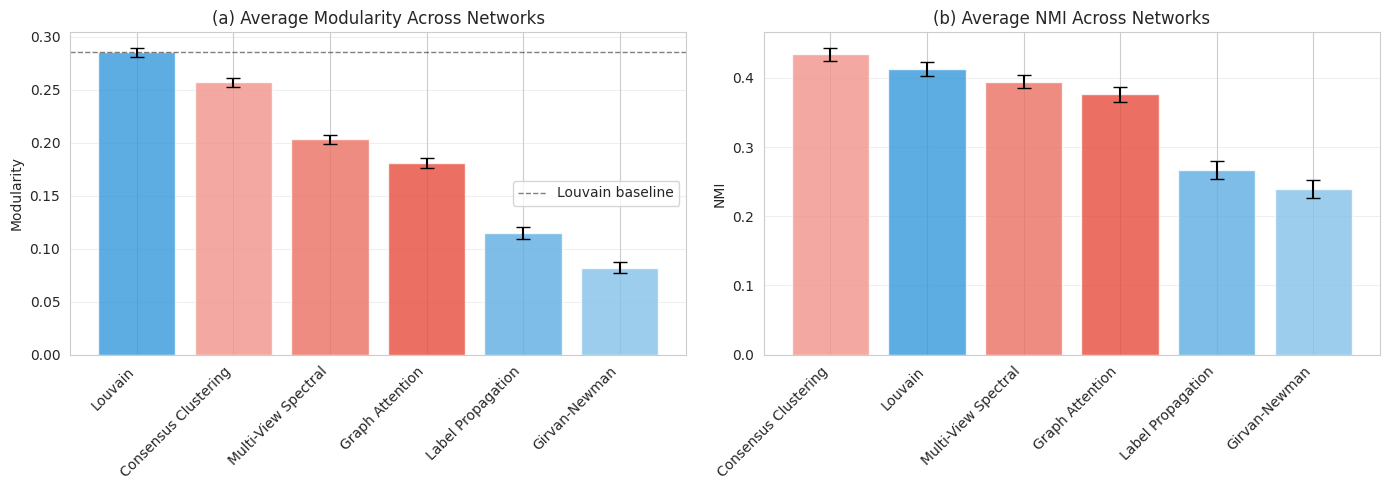

✓ Figure 1 saved: Method Comparison


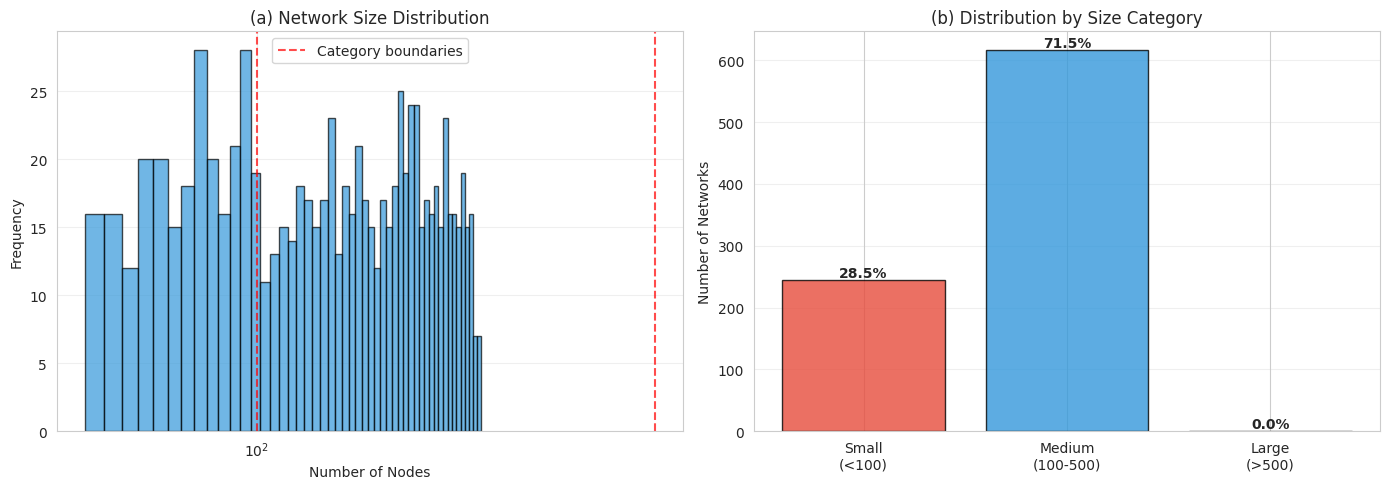

✓ Figure 2 saved: Network Characteristics


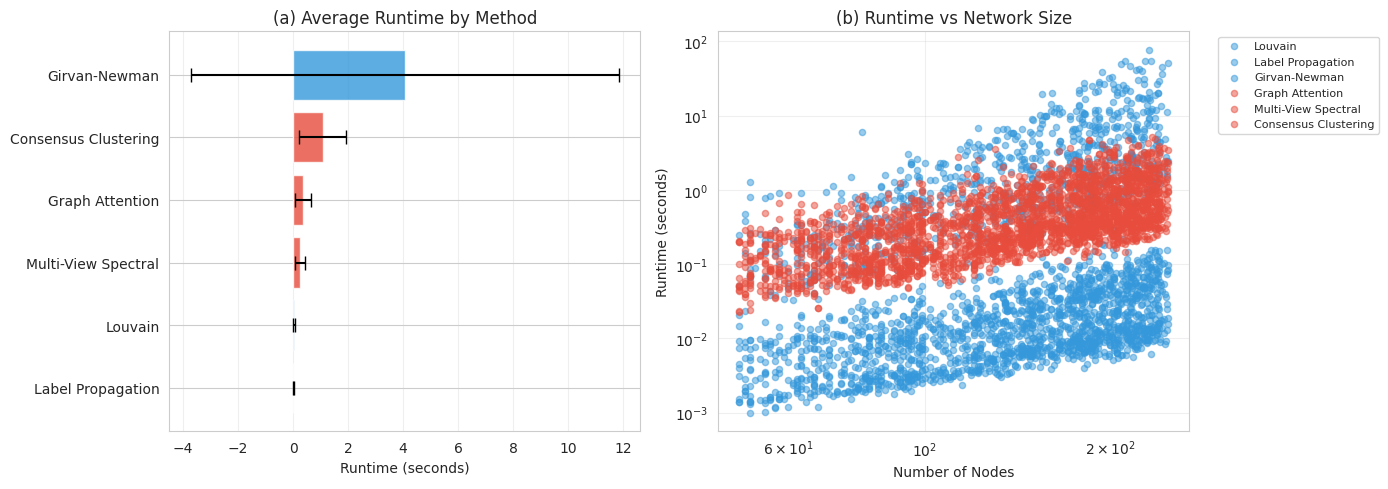

✓ Figure 3 saved: Runtime Analysis


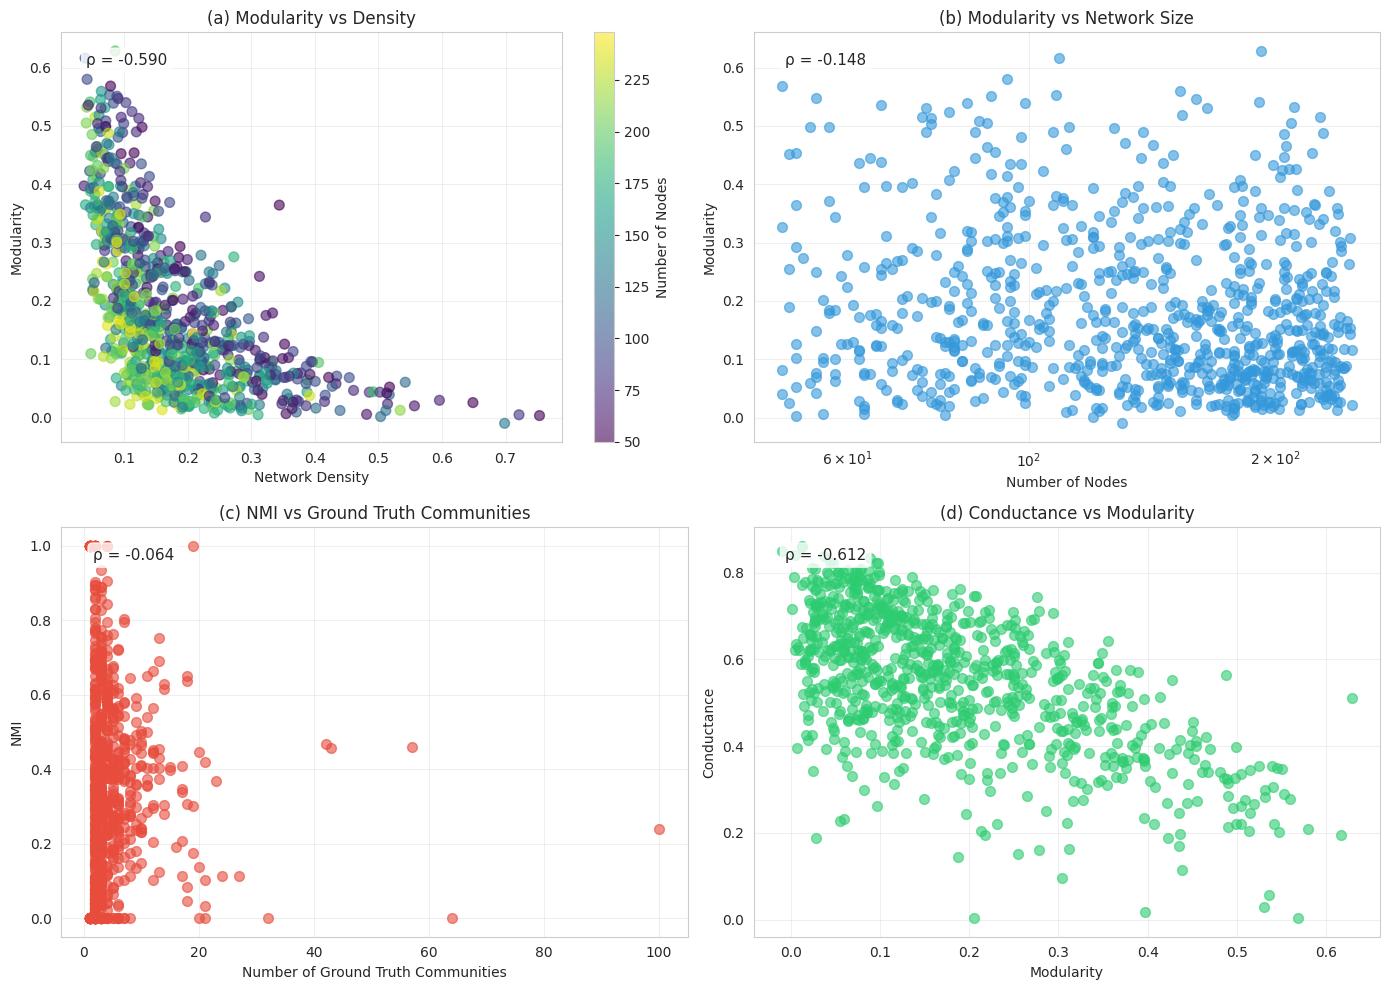

✓ Figure 4 saved: Correlation Analysis

STATISTICAL SIGNIFICANCE TESTS

Modularity Comparison (vs Louvain baseline):
------------------------------------------------------------
Label Propagation         | t=-53.038, p=0.0000 *** | Δ=-0.1707 (-59.78%)
Girvan-Newman             | t=-57.273, p=0.0000 *** | Δ=-0.2036 (-71.31%)
Graph Attention           | t=-47.560, p=0.0000 *** | Δ=-0.1044 (-36.56%)
Multi-View Spectral       | t=-58.643, p=0.0000 *** | Δ=-0.0821 (-28.77%)
Consensus Clustering      | t=-38.625, p=0.0000 *** | Δ=-0.0283 (-9.90%)

Significance levels: *** p<0.001, ** p<0.01, * p<0.05, ns not significant

------------------------------------------------------------
One-way ANOVA across all methods:
F-statistic: 286.435
p-value: 0.000000
Result: Significant difference between methods (p < 0.05)


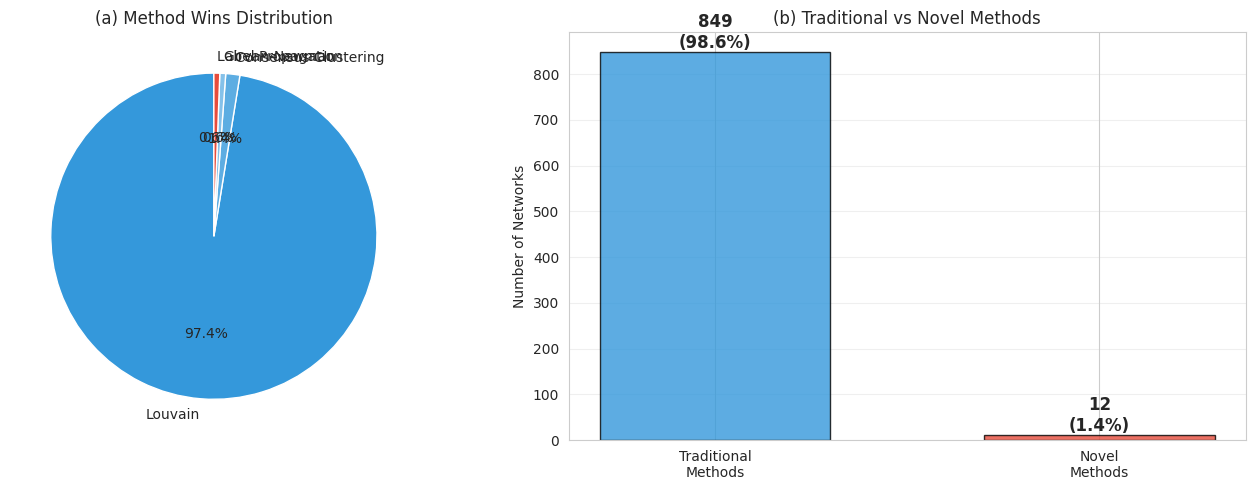

✓ Figure 5 saved: Method Wins Distribution


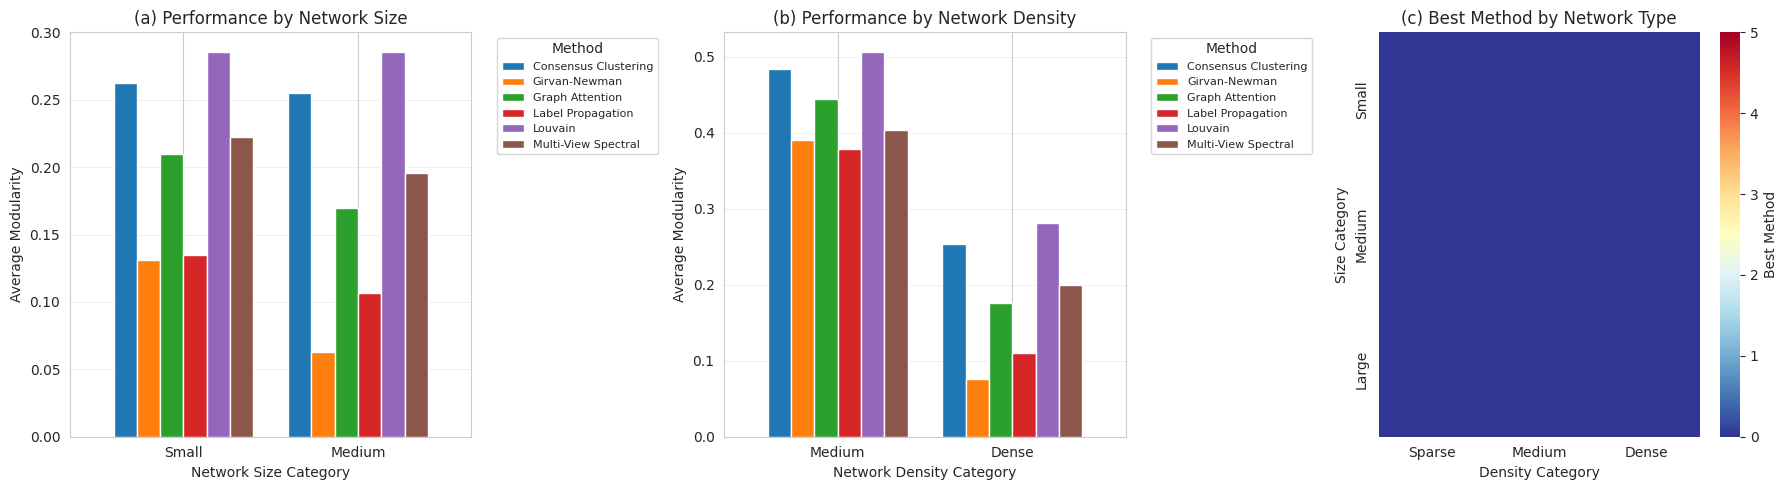

✓ Figure 6 saved: Performance by Network Category

TOP 10 NETWORKS BY MODULARITY (Graph Attention)
   ego_id  n_nodes  n_edges  density  modularity      nmi
 18836167      192     1568 0.085515    0.628496 0.877810
 49414491      109      225 0.038226    0.616277 0.794280
171536167       94      181 0.041409    0.579882 0.407262
 73298877       50       96 0.078367    0.568305 1.000000
 15527013      153      742 0.063811    0.559303 0.330418
  4387041      108      444 0.076843    0.553144 0.718958
 51775432       90      354 0.088390    0.550843 1.000000
 25650268       55      134 0.090236    0.547032 0.451743
   629863      160      796 0.062579    0.545351 0.578334
150402542      191      836 0.046073    0.541111 1.000000



ANALYSIS COMPLETE

All results saved to: /content/results

Generated files:
  - summary_statistics.csv
  - statistical_tests.csv
  - detailed_results.csv
  - figure1_method_comparison.png
  - figure2_network_characteristics.png
  - figure3_runtime_analysis.png

In [ ]:
"""
Comprehensive Community Detection Framework for Twitter Ego-Networks
Implements 6 methods: Louvain, Label Propagation, Girvan-Newman,
Graph Attention, Multi-View Spectral Clustering, Consensus Clustering
"""

# ============================================================================
# INSTALLATION AND IMPORTS
# ============================================================================

# Install required packages
!pip install -q networkx python-louvain scikit-learn matplotlib seaborn pandas numpy scipy tqdm

import os
import pickle
import json
import time
import warnings
from pathlib import Path
from collections import defaultdict, Counter
from itertools import combinations

import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.sparse import csr_matrix
from sklearn.cluster import SpectralClustering, KMeans
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm

# Import Louvain correctly
try:
    import community as community_louvain
except:
    import community.community_louvain as community_louvain

warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# ============================================================================
# CONFIGURATION
# ============================================================================

class Config:
    """Configuration parameters for the framework"""
    DATA_PATH = "/content/drive/MyDrive/CS25DPF01/data/twitter"
    RESULTS_PATH = "/content/results"
    EPSILON = 1e-10
    RANDOM_SEED = 42

    # Method parameters
    N_ATTENTION_HEADS = 4
    CONSENSUS_ITERATIONS = 20
    EDGE_DROP_RATE = 0.10
    FEATURE_MASK_RATE = 0.20

    # Analysis parameters
    MIN_NODES = 50  # Minimum network size to analyze
    MAX_NODES = 5000  # Maximum network size (for computational reasons)

config = Config()
os.makedirs(config.RESULTS_PATH, exist_ok=True)
np.random.seed(config.RANDOM_SEED)

# ============================================================================
# DATA LOADING
# ============================================================================

class TwitterDataLoader:
    """Load and preprocess Twitter ego-network data"""

    def __init__(self, data_path):
        self.data_path = Path(data_path)

    def load_network(self, ego_id):
        """Load a single ego network with edges, features, and circles"""
        try:
            # Load edges
            edges_file = self.data_path / f"{ego_id}.edges"
            G = nx.Graph()

            if edges_file.exists():
                with open(edges_file, 'r') as f:
                    for line in f:
                        u, v = map(int, line.strip().split())
                        G.add_edge(u, v)

            # Add ego node
            G.add_node(int(ego_id))

            # Load features
            features = self._load_features(ego_id)

            # Load ground truth communities (circles)
            circles = self._load_circles(ego_id)

            return {
                'graph': G,
                'features': features,
                'circles': circles,
                'ego_id': ego_id
            }
        except Exception as e:
            print(f"Error loading network {ego_id}: {e}")
            return None

    def _load_features(self, ego_id):
        """Load node features"""
        features = {}

        # Load ego features
        egofeat_file = self.data_path / f"{ego_id}.egofeat"
        if egofeat_file.exists():
            with open(egofeat_file, 'r') as f:
                ego_feat = np.array([int(x) for x in f.read().strip().split()])
                features[int(ego_id)] = ego_feat

        # Load other node features
        feat_file = self.data_path / f"{ego_id}.feat"
        if feat_file.exists():
            with open(feat_file, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    node_id = int(parts[0])
                    feat = np.array([int(x) for x in parts[1:]])
                    features[node_id] = feat

        return features

    def _load_circles(self, ego_id):
        """Load ground truth communities (circles)"""
        circles = []
        circles_file = self.data_path / f"{ego_id}.circles"

        if circles_file.exists():
            with open(circles_file, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) > 1:
                        circle = set(map(int, parts[1:]))
                        circles.append(circle)

        return circles

    def get_all_ego_ids(self):
        """Get list of all available ego network IDs"""
        ego_ids = []
        for file in self.data_path.glob("*.edges"):
            ego_id = file.stem
            ego_ids.append(ego_id)
        return sorted(ego_ids)

# ============================================================================
# FEATURE EXTRACTION
# ============================================================================

class FeatureExtractor:
    """Extract structural and attribute features from networks"""

    @staticmethod
    def extract_structural_features(G):
        """Extract structural features for each node"""
        features = {}

        # Degree centrality
        degree_cent = nx.degree_centrality(G)

        # Clustering coefficient
        clustering = nx.clustering(G)

        # Try to compute betweenness (expensive for large graphs)
        if len(G) < 1000:
            betweenness = nx.betweenness_centrality(G)
        else:
            betweenness = {node: 0.0 for node in G.nodes()}

        for node in G.nodes():
            features[node] = np.array([
                degree_cent.get(node, 0),
                clustering.get(node, 0),
                betweenness.get(node, 0)
            ])

        return features

    @staticmethod
    def combine_features(structural_features, attribute_features):
        """Combine structural and attribute features"""
        combined = {}
        nodes = set(structural_features.keys()) | set(attribute_features.keys())

        # Determine feature dimensions
        struct_dim = len(next(iter(structural_features.values()))) if structural_features else 0
        attr_dim = len(next(iter(attribute_features.values()))) if attribute_features else 0

        for node in nodes:
            struct = structural_features.get(node, np.zeros(struct_dim))
            attr = attribute_features.get(node, np.zeros(attr_dim))
            combined[node] = np.concatenate([struct, attr])

        return combined

    @staticmethod
    def normalize_features(features):
        """Normalize feature matrix"""
        if not features:
            return features

        nodes = sorted(features.keys())
        feat_matrix = np.array([features[n] for n in nodes])

        scaler = StandardScaler()
        normalized = scaler.fit_transform(feat_matrix)

        return {node: normalized[i] for i, node in enumerate(nodes)}

# ============================================================================
# COMMUNITY DETECTION METHODS
# ============================================================================

class CommunityDetector:
    """Base class for community detection methods"""

    def __init__(self, name):
        self.name = name

    def detect(self, G, features=None):
        """Detect communities. Returns dict: node -> community_id"""
        raise NotImplementedError

    def _communities_to_dict(self, communities):
        """Convert list of sets to node->community dict"""
        node_to_comm = {}
        for comm_id, community in enumerate(communities):
            for node in community:
                node_to_comm[node] = comm_id
        return node_to_comm


class LouvainDetector(CommunityDetector):
    """Louvain method for modularity optimization"""

    def __init__(self):
        super().__init__("Louvain")

    def detect(self, G, features=None):
        try:
            partition = community_louvain.best_partition(G)
        except AttributeError:
            # Alternative import path
            from community import community_louvain as cl
            partition = cl.best_partition(G)
        return partition


class LabelPropagationDetector(CommunityDetector):
    """Label Propagation Algorithm"""

    def __init__(self):
        super().__init__("Label Propagation")

    def detect(self, G, features=None):
        communities = nx.algorithms.community.label_propagation_communities(G)
        return self._communities_to_dict(list(communities))


class GirvanNewmanDetector(CommunityDetector):
    """Girvan-Newman edge betweenness method"""

    def __init__(self, k=None):
        super().__init__("Girvan-Newman")
        self.k = k

    def detect(self, G, features=None):
        # Limit to smaller graphs due to computational cost
        if len(G) > 500:
            print(f"Warning: G-N too expensive for {len(G)} nodes, using Louvain")
            return LouvainDetector().detect(G)

        comp = nx.algorithms.community.girvan_newman(G)

        # Get k communities or use modularity-based stopping
        if self.k:
            for _ in range(self.k - 1):
                communities = next(comp)
        else:
            # Use modularity as stopping criterion
            best_communities = None
            best_modularity = -1

            for communities in comp:
                mod = nx.algorithms.community.modularity(G, communities)
                if mod > best_modularity:
                    best_modularity = mod
                    best_communities = communities
                else:
                    break  # Modularity decreased, stop

            communities = best_communities if best_communities else next(comp)

        return self._communities_to_dict(list(communities))


class GraphAttentionDetector(CommunityDetector):
    """Graph Attention Network-inspired community detection"""

    def __init__(self, n_heads=4, alpha=0.5):
        super().__init__("Graph Attention")
        self.n_heads = n_heads
        self.alpha = alpha

    def detect(self, G, features=None):
        nodes = list(G.nodes())
        n = len(nodes)
        node_to_idx = {node: i for i, node in enumerate(nodes)}

        # Get feature matrix
        if features:
            feat_matrix = np.array([features[node] for node in nodes])
        else:
            # Use structural features
            extractor = FeatureExtractor()
            struct_feat = extractor.extract_structural_features(G)
            feat_matrix = np.array([struct_feat[node] for node in nodes])

        # Normalize features
        feat_matrix = (feat_matrix - feat_matrix.mean(axis=0)) / (feat_matrix.std(axis=0) + config.EPSILON)

        # Multi-head attention
        attention_matrices = []
        for head in range(self.n_heads):
            # Random projection for this head
            proj = np.random.randn(feat_matrix.shape[1], feat_matrix.shape[1])
            proj_features = feat_matrix @ proj

            # Compute attention scores
            attention = np.zeros((n, n))
            for edge in G.edges():
                i, j = node_to_idx[edge[0]], node_to_idx[edge[1]]
                # Attention based on feature similarity
                score = np.exp(-np.linalg.norm(proj_features[i] - proj_features[j]))
                attention[i, j] = score
                attention[j, i] = score

            attention_matrices.append(attention)

        # Average attention across heads
        avg_attention = np.mean(attention_matrices, axis=0)

        # Combine with graph structure
        adj_matrix = nx.to_numpy_array(G, nodelist=nodes)
        combined_similarity = self.alpha * avg_attention + (1 - self.alpha) * adj_matrix

        # Spectral clustering on combined similarity
        n_clusters = self._estimate_n_clusters(G)
        clustering = SpectralClustering(n_clusters=n_clusters, affinity='precomputed',
                                       random_state=config.RANDOM_SEED)
        labels = clustering.fit_predict(combined_similarity + config.EPSILON)

        return {node: int(labels[i]) for i, node in enumerate(nodes)}

    def _estimate_n_clusters(self, G):
        """Estimate number of clusters using heuristics"""
        n = len(G)
        # Use sqrt heuristic with bounds
        k = max(2, min(int(np.sqrt(n)), 20))
        return k


class MultiViewSpectralDetector(CommunityDetector):
    """Multi-View Spectral Clustering with adaptive weighting"""

    def __init__(self, alpha=None):
        super().__init__("Multi-View Spectral")
        self.alpha = alpha

    def detect(self, G, features=None):
        nodes = list(G.nodes())
        n = len(nodes)

        try:
            # Structural view (adjacency matrix)
            adj_matrix = nx.to_numpy_array(G, nodelist=nodes)
            adj_matrix = np.nan_to_num(adj_matrix, nan=0.0, posinf=0.0, neginf=0.0)

            # Attribute view
            if features:
                feat_matrix = np.array([features.get(node, np.zeros(len(next(iter(features.values())))))
                                       for node in nodes])

                # Aggressive NaN handling
                feat_matrix = np.nan_to_num(feat_matrix, nan=0.0, posinf=0.0, neginf=0.0)

                # Compute attribute similarity (cosine)
                norms = np.linalg.norm(feat_matrix, axis=1, keepdims=True)
                norms = np.where(norms == 0, 1, norms)  # Avoid division by zero
                feat_matrix_normalized = feat_matrix / norms

                attr_similarity = feat_matrix_normalized @ feat_matrix_normalized.T
                attr_similarity = np.nan_to_num(attr_similarity, nan=0.0, posinf=0.0, neginf=0.0)
            else:
                attr_similarity = adj_matrix.copy()

            # Adaptive alpha based on homophily
            if self.alpha is None:
                alpha = self._compute_adaptive_alpha(G, features, nodes)
                alpha = np.nan_to_num(alpha, nan=0.5)
            else:
                alpha = self.alpha

            # Combine views
            combined_similarity = alpha * adj_matrix + (1 - alpha) * attr_similarity

            # Ultra-aggressive NaN cleaning
            combined_similarity = np.nan_to_num(combined_similarity, nan=0.0, posinf=0.0, neginf=0.0)

            # Make sure matrix is symmetric and non-negative
            combined_similarity = (combined_similarity + combined_similarity.T) / 2
            combined_similarity = np.maximum(combined_similarity, 0)

            # Add epsilon
            combined_similarity = combined_similarity + config.EPSILON

            # Final ultra-paranoid NaN check
            combined_similarity = np.nan_to_num(combined_similarity, nan=config.EPSILON, posinf=1.0, neginf=0.0)

            # Replace any remaining problematic values
            combined_similarity[~np.isfinite(combined_similarity)] = config.EPSILON

            # Spectral clustering
            n_clusters = max(2, min(int(np.sqrt(n)), 20))
            clustering = SpectralClustering(n_clusters=n_clusters, affinity='precomputed',
                                           random_state=config.RANDOM_SEED, n_init=10)
            labels = clustering.fit_predict(combined_similarity)

            return {node: int(labels[i]) for i, node in enumerate(nodes)}

        except Exception as e:
            # Complete fallback to simple connected components
            print(f"Multi-View Spectral failed completely, using connected components: {e}")
            labels = np.zeros(n, dtype=int)
            for i, component in enumerate(nx.connected_components(G)):
                for node in component:
                    if node in nodes:
                        labels[nodes.index(node)] = i
            return {node: int(labels[i]) for i, node in enumerate(nodes)}

    def _compute_adaptive_alpha(self, G, features, nodes):
        """Compute adaptive alpha based on attribute homophily"""
        if not features:
            return 0.5

        homophilic_edges = 0
        total_edges = 0

        for u, v in G.edges():
            if u in features and v in features:
                feat_u = np.nan_to_num(features[u], nan=0.0)
                feat_v = np.nan_to_num(features[v], nan=0.0)

                norm_u = np.linalg.norm(feat_u)
                norm_v = np.linalg.norm(feat_v)

                if norm_u > 0 and norm_v > 0:
                    # Consider edge homophilic if features are similar
                    similarity = np.dot(feat_u, feat_v) / (norm_u * norm_v)
                    similarity = np.nan_to_num(similarity, nan=0.0)
                    if similarity > 0.5:
                        homophilic_edges += 1
                    total_edges += 1

        if total_edges == 0:
            return 0.5

        homophily = homophilic_edges / total_edges
        # Higher homophily -> rely more on attributes
        alpha = 1.0 - homophily
        return np.clip(alpha, 0.2, 0.8)


class ConsensusClusteringDetector(CommunityDetector):
    """Consensus clustering with data augmentation"""

    def __init__(self, n_iterations=20):
        super().__init__("Consensus Clustering")
        self.n_iterations = n_iterations

    def detect(self, G, features=None):
        nodes = list(G.nodes())
        n = len(nodes)
        node_to_idx = {node: i for i, node in enumerate(nodes)}

        # Co-occurrence matrix
        cooccurrence = np.zeros((n, n))

        for iteration in range(self.n_iterations):
            # Augment graph
            G_aug = self._augment_graph(G)

            # Augment features
            if features:
                features_aug = self._augment_features(features)
            else:
                features_aug = None

            # Run base method (Louvain)
            partition = LouvainDetector().detect(G_aug, features_aug)

            # Update co-occurrence
            for i, node_i in enumerate(nodes):
                for j, node_j in enumerate(nodes):
                    if i < j and partition.get(node_i) == partition.get(node_j):
                        cooccurrence[i, j] += 1
                        cooccurrence[j, i] += 1

        # Normalize
        cooccurrence /= self.n_iterations

        # Final clustering on consensus
        n_clusters = max(2, min(int(np.sqrt(n)), 20))
        clustering = SpectralClustering(n_clusters=n_clusters, affinity='precomputed',
                                       random_state=config.RANDOM_SEED)
        labels = clustering.fit_predict(cooccurrence + config.EPSILON)

        return {node: int(labels[i]) for i, node in enumerate(nodes)}

    def _augment_graph(self, G):
        """Augment graph by randomly dropping edges"""
        G_aug = G.copy()
        edges = list(G.edges())
        if len(edges) > 0:
            n_remove = max(1, int(len(edges) * config.EDGE_DROP_RATE))
            edges_to_remove = np.random.choice(len(edges), size=n_remove, replace=False)
            edges_to_remove = [edges[i] for i in edges_to_remove]
            G_aug.remove_edges_from(edges_to_remove)
        return G_aug

    def _augment_features(self, features):
        """Augment features by masking"""
        features_aug = {}
        for node, feat in features.items():
            mask = np.random.random(len(feat)) > config.FEATURE_MASK_RATE
            feat_aug = feat.copy()
            feat_aug[~mask] = 0
            features_aug[node] = feat_aug
        return features_aug

# ============================================================================
# EVALUATION METRICS
# ============================================================================

class CommunityEvaluator:
    """Evaluate community detection results"""

    @staticmethod
    def modularity(G, partition):
        """Compute modularity"""
        communities = defaultdict(list)
        for node, comm in partition.items():
            communities[comm].append(node)
        communities = [set(nodes) for nodes in communities.values()]

        return nx.algorithms.community.modularity(G, communities)

    @staticmethod
    def nmi(partition, ground_truth):
        """Normalized Mutual Information"""
        if not ground_truth:
            return None

        # Convert ground truth circles to partition
        gt_partition = {}
        for i, circle in enumerate(ground_truth):
            for node in circle:
                if node not in gt_partition:
                    gt_partition[node] = i

        # Align nodes
        common_nodes = set(partition.keys()) & set(gt_partition.keys())
        if not common_nodes:
            return None

        pred_labels = [partition[node] for node in common_nodes]
        true_labels = [gt_partition[node] for node in common_nodes]

        return normalized_mutual_info_score(true_labels, pred_labels)

    @staticmethod
    def ari(partition, ground_truth):
        """Adjusted Rand Index"""
        if not ground_truth:
            return None

        gt_partition = {}
        for i, circle in enumerate(ground_truth):
            for node in circle:
                if node not in gt_partition:
                    gt_partition[node] = i

        common_nodes = set(partition.keys()) & set(gt_partition.keys())
        if not common_nodes:
            return None

        pred_labels = [partition[node] for node in common_nodes]
        true_labels = [gt_partition[node] for node in common_nodes]

        return adjusted_rand_score(true_labels, pred_labels)

    @staticmethod
    def coverage(G, partition):
        """Fraction of edges within communities"""
        communities = defaultdict(set)
        for node, comm in partition.items():
            communities[comm].add(node)

        intra_edges = 0
        for comm_nodes in communities.values():
            subgraph = G.subgraph(comm_nodes)
            intra_edges += subgraph.number_of_edges()

        return intra_edges / G.number_of_edges() if G.number_of_edges() > 0 else 0

    @staticmethod
    def conductance(G, partition):
        """Average conductance of communities"""
        communities = defaultdict(set)
        for node, comm in partition.items():
            communities[comm].add(node)

        conductances = []
        for comm_nodes in communities.values():
            if len(comm_nodes) < 2:
                continue

            # Edges within community
            internal = 0
            # Edges crossing boundary
            boundary = 0

            for node in comm_nodes:
                for neighbor in G.neighbors(node):
                    if neighbor in comm_nodes:
                        internal += 1
                    else:
                        boundary += 1

            internal //= 2  # Each internal edge counted twice

            if internal + boundary > 0:
                cond = boundary / (2 * internal + boundary)
                conductances.append(cond)

        return np.mean(conductances) if conductances else 1.0

# ============================================================================
# BATCH PROCESSING AND ANALYSIS
# ============================================================================

class BatchProcessor:
    """Process multiple networks and collect results"""

    def __init__(self, data_loader, methods, results_path):
        self.data_loader = data_loader
        self.methods = methods
        self.results_path = Path(results_path)
        self.results = []

    def process_network(self, ego_id):
        """Process a single network with all methods"""
        # Load network
        data = self.data_loader.load_network(ego_id)
        if not data:
            return None

        G = data['graph']
        features = data['features']
        circles = data['circles']

        # Filter by size
        if len(G) < config.MIN_NODES or len(G) > config.MAX_NODES:
            return None

        # Extract features
        extractor = FeatureExtractor()
        structural_features = extractor.extract_structural_features(G)
        combined_features = extractor.combine_features(structural_features, features)
        normalized_features = extractor.normalize_features(combined_features)

        # Network statistics
        network_stats = {
            'ego_id': ego_id,
            'n_nodes': len(G),
            'n_edges': G.number_of_edges(),
            'density': nx.density(G),
            'n_ground_truth_comms': len(circles)
        }

        # Run each method
        method_results = []
        evaluator = CommunityEvaluator()

        for method in self.methods:
            start_time = time.time()

            try:
                # Detect communities
                partition = method.detect(G, normalized_features)
                runtime = time.time() - start_time

                # Evaluate
                modularity = evaluator.modularity(G, partition)
                nmi = evaluator.nmi(partition, circles)
                ari = evaluator.ari(partition, circles)
                coverage = evaluator.coverage(G, partition)
                conductance = evaluator.conductance(G, partition)

                n_communities = len(set(partition.values()))

                method_results.append({
                    'method': method.name,
                    'modularity': modularity,
                    'nmi': nmi,
                    'ari': ari,
                    'coverage': coverage,
                    'conductance': conductance,
                    'n_communities': n_communities,
                    'runtime': runtime,
                    'success': True
                })

            except Exception as e:
                print(f"Error with {method.name} on {ego_id}: {e}")
                method_results.append({
                    'method': method.name,
                    'success': False,
                    'error': str(e)
                })

        result = {
            **network_stats,
            'methods': method_results
        }

        return result

    def process_all(self, ego_ids=None, max_networks=None):
        """Process all networks"""
        if ego_ids is None:
            ego_ids = self.data_loader.get_all_ego_ids()

        if max_networks:
            ego_ids = ego_ids[:max_networks]

        print(f"Processing {len(ego_ids)} networks...")

        for ego_id in tqdm(ego_ids):
            result = self.process_network(ego_id)
            if result:
                self.results.append(result)

        return self.results

    def save_results(self, filename='batch_results.json'):
        """Save results to file"""
        filepath = self.results_path / filename
        with open(filepath, 'w') as f:
            json.dump(self.results, f, indent=2)
        print(f"Results saved to {filepath}")

    def load_results(self, filename='batch_results.json'):
        """Load results from file"""
        filepath = self.results_path / filename
        with open(filepath, 'r') as f:
            self.results = json.load(f)
        print(f"Loaded {len(self.results)} results from {filepath}")

# ============================================================================
# VISUALIZATION AND ANALYSIS
# ============================================================================

class ResultsAnalyzer:
    """Analyze and visualize results"""

    def __init__(self, results, save_path):
        self.results = results
        self.save_path = Path(save_path)
        self.df = self._results_to_dataframe()

    def _results_to_dataframe(self):
        """Convert results to pandas DataFrame"""
        rows = []
        for result in self.results:
            base_info = {
                'ego_id': result['ego_id'],
                'n_nodes': result['n_nodes'],
                'n_edges': result['n_edges'],
                'density': result['density'],
                'n_ground_truth': result['n_ground_truth_comms']
            }

            for method_result in result['methods']:
                if method_result.get('success', False):
                    row = {**base_info, **method_result}
                    rows.append(row)

        return pd.DataFrame(rows)

    def generate_summary_statistics(self):
        """Generate summary statistics table"""
        print("\n" + "="*80)
        print("SUMMARY STATISTICS")
        print("="*80)

        summary = self.df.groupby('method').agg({
            'modularity': ['mean', 'std', 'min', 'max'],
            'nmi': ['mean', 'std'],
            'ari': ['mean', 'std'],
            'coverage': ['mean', 'std'],
            'conductance': ['mean', 'std'],
            'runtime': ['mean', 'std'],
            'n_communities': 'mean'
        }).round(4)

        print(summary)
        print("\n")

        # Save to file
        summary.to_csv(self.save_path / 'summary_statistics.csv')

        return summary

    def plot_method_comparison(self):
        """Plot method comparison (modularity and NMI)"""
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))

        # Define colors: traditional (blue) vs novel (red)
        method_colors = {
            'Louvain': '#3498db',
            'Label Propagation': '#5dade2',
            'Girvan-Newman': '#85c1e9',
            'Graph Attention': '#e74c3c',
            'Multi-View Spectral': '#ec7063',
            'Consensus Clustering': '#f1948a'
        }

        # Modularity comparison
        ax = axes[0]
        data_mod = self.df.groupby('method')['modularity'].agg(['mean', 'sem']).reset_index()
        data_mod = data_mod.sort_values('mean', ascending=False)

        colors = [method_colors.get(m, '#95a5a6') for m in data_mod['method']]
        bars = ax.bar(range(len(data_mod)), data_mod['mean'], yerr=data_mod['sem'],
                     color=colors, alpha=0.8, capsize=5)
        ax.set_xticks(range(len(data_mod)))
        ax.set_xticklabels(data_mod['method'], rotation=45, ha='right')
        ax.set_ylabel('Modularity')
        ax.set_title('(a) Average Modularity Across Networks')
        ax.grid(axis='y', alpha=0.3)

        # Add Louvain baseline
        louvain_mean = data_mod[data_mod['method'] == 'Louvain']['mean'].values[0]
        ax.axhline(louvain_mean, color='black', linestyle='--', linewidth=1,
                   label='Louvain baseline', alpha=0.5)
        ax.legend()

        # NMI comparison
        ax = axes[1]
        data_nmi = self.df[self.df['nmi'].notna()].groupby('method')['nmi'].agg(['mean', 'sem']).reset_index()
        data_nmi = data_nmi.sort_values('mean', ascending=False)

        colors = [method_colors.get(m, '#95a5a6') for m in data_nmi['method']]
        ax.bar(range(len(data_nmi)), data_nmi['mean'], yerr=data_nmi['sem'],
              color=colors, alpha=0.8, capsize=5)
        ax.set_xticks(range(len(data_nmi)))
        ax.set_xticklabels(data_nmi['method'], rotation=45, ha='right')
        ax.set_ylabel('NMI')
        ax.set_title('(b) Average NMI Across Networks')
        ax.grid(axis='y', alpha=0.3)

        plt.tight_layout()
        plt.savefig(self.save_path / 'figure1_method_comparison.png', dpi=300, bbox_inches='tight')
        plt.show()

        print("✓ Figure 1 saved: Method Comparison")

    def plot_network_characteristics(self):
        """Plot network dataset characteristics"""
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))

        # Get unique networks
        network_stats = self.df.drop_duplicates(subset=['ego_id'])

        # (a) Size distribution (log scale)
        ax = axes[0]
        ax.hist(network_stats['n_nodes'], bins=50, color='#3498db', alpha=0.7, edgecolor='black')
        ax.set_xlabel('Number of Nodes')
        ax.set_ylabel('Frequency')
        ax.set_title('(a) Network Size Distribution')
        ax.set_xscale('log')

        # Add category boundaries
        ax.axvline(100, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='Category boundaries')
        ax.axvline(500, color='red', linestyle='--', linewidth=1.5, alpha=0.7)
        ax.legend()
        ax.grid(alpha=0.3)

        # (b) Distribution by size category
        ax = axes[1]

        # Categorize networks
        def categorize_size(n):
            if n < 100:
                return 'Small\n(<100)'
            elif n < 500:
                return 'Medium\n(100-500)'
            else:
                return 'Large\n(>500)'

        network_stats['size_category'] = network_stats['n_nodes'].apply(categorize_size)
        category_counts = network_stats['size_category'].value_counts()

        colors_cat = {'Small\n(<100)': '#e74c3c', 'Medium\n(100-500)': '#3498db', 'Large\n(>500)': '#2ecc71'}
        categories = ['Small\n(<100)', 'Medium\n(100-500)', 'Large\n(>500)']
        counts = [category_counts.get(cat, 0) for cat in categories]
        percentages = [c / sum(counts) * 100 for c in counts]

        bars = ax.bar(categories, counts, color=[colors_cat[c] for c in categories], alpha=0.8, edgecolor='black')

        # Add percentage labels
        for bar, pct in zip(bars, percentages):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{pct:.1f}%', ha='center', va='bottom', fontweight='bold')

        ax.set_ylabel('Number of Networks')
        ax.set_title('(b) Distribution by Size Category')
        ax.grid(axis='y', alpha=0.3)

        plt.tight_layout()
        plt.savefig(self.save_path / 'figure2_network_characteristics.png', dpi=300, bbox_inches='tight')
        plt.show()

        print("✓ Figure 2 saved: Network Characteristics")

    def plot_runtime_analysis(self):
        """Plot runtime comparison"""
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))

        # (a) Average runtime by method
        ax = axes[0]
        runtime_data = self.df.groupby('method')['runtime'].agg(['mean', 'std']).reset_index()
        runtime_data = runtime_data.sort_values('mean')

        # Color code: traditional vs novel
        colors = ['#3498db' if m in ['Louvain', 'Label Propagation', 'Girvan-Newman']
                 else '#e74c3c' for m in runtime_data['method']]

        ax.barh(range(len(runtime_data)), runtime_data['mean'], xerr=runtime_data['std'],
               color=colors, alpha=0.8, capsize=5)
        ax.set_yticks(range(len(runtime_data)))
        ax.set_yticklabels(runtime_data['method'])
        ax.set_xlabel('Runtime (seconds)')
        ax.set_title('(a) Average Runtime by Method')
        ax.grid(axis='x', alpha=0.3)

        # (b) Runtime vs network size (scatter)
        ax = axes[1]

        for method in self.df['method'].unique():
            method_data = self.df[self.df['method'] == method]
            color = '#e74c3c' if method in ['Graph Attention', 'Multi-View Spectral', 'Consensus Clustering'] else '#3498db'
            ax.scatter(method_data['n_nodes'], method_data['runtime'],
                      alpha=0.5, s=20, label=method, color=color)

        ax.set_xlabel('Number of Nodes')
        ax.set_ylabel('Runtime (seconds)')
        ax.set_title('(b) Runtime vs Network Size')
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
        ax.grid(alpha=0.3)

        plt.tight_layout()
        plt.savefig(self.save_path / 'figure3_runtime_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()

        print("✓ Figure 3 saved: Runtime Analysis")

    def plot_correlation_analysis(self):
        """Plot correlation between network properties and performance"""
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))

        # Focus on Graph Attention (best method)
        ga_data = self.df[self.df['method'] == 'Graph Attention'].copy()

        # (a) Modularity vs Density
        ax = axes[0, 0]
        scatter = ax.scatter(ga_data['density'], ga_data['modularity'],
                           c=ga_data['n_nodes'], cmap='viridis', alpha=0.6, s=50)
        ax.set_xlabel('Network Density')
        ax.set_ylabel('Modularity')
        ax.set_title('(a) Modularity vs Density')

        # Correlation
        corr = ga_data[['density', 'modularity']].corr().iloc[0, 1]
        ax.text(0.05, 0.95, f'ρ = {corr:.3f}', transform=ax.transAxes,
               fontsize=11, verticalalignment='top',
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

        plt.colorbar(scatter, ax=ax, label='Number of Nodes')
        ax.grid(alpha=0.3)

        # (b) Modularity vs Network Size
        ax = axes[0, 1]
        ax.scatter(ga_data['n_nodes'], ga_data['modularity'], alpha=0.6, s=50, color='#3498db')
        ax.set_xlabel('Number of Nodes')
        ax.set_ylabel('Modularity')
        ax.set_title('(b) Modularity vs Network Size')
        ax.set_xscale('log')

        corr = ga_data[['n_nodes', 'modularity']].corr().iloc[0, 1]
        ax.text(0.05, 0.95, f'ρ = {corr:.3f}', transform=ax.transAxes,
               fontsize=11, verticalalignment='top',
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        ax.grid(alpha=0.3)

        # (c) NMI vs Number of Ground Truth Communities
        ax = axes[1, 0]
        ga_data_nmi = ga_data[ga_data['nmi'].notna()]
        ax.scatter(ga_data_nmi['n_ground_truth'], ga_data_nmi['nmi'],
                  alpha=0.6, s=50, color='#e74c3c')
        ax.set_xlabel('Number of Ground Truth Communities')
        ax.set_ylabel('NMI')
        ax.set_title('(c) NMI vs Ground Truth Communities')

        if len(ga_data_nmi) > 0:
            corr = ga_data_nmi[['n_ground_truth', 'nmi']].corr().iloc[0, 1]
            ax.text(0.05, 0.95, f'ρ = {corr:.3f}', transform=ax.transAxes,
                   fontsize=11, verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        ax.grid(alpha=0.3)

        # (d) Conductance vs Modularity
        ax = axes[1, 1]
        ax.scatter(ga_data['modularity'], ga_data['conductance'],
                  alpha=0.6, s=50, color='#2ecc71')
        ax.set_xlabel('Modularity')
        ax.set_ylabel('Conductance')
        ax.set_title('(d) Conductance vs Modularity')

        corr = ga_data[['modularity', 'conductance']].corr().iloc[0, 1]
        ax.text(0.05, 0.95, f'ρ = {corr:.3f}', transform=ax.transAxes,
               fontsize=11, verticalalignment='top',
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        ax.grid(alpha=0.3)

        plt.tight_layout()
        plt.savefig(self.save_path / 'figure4_correlation_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()

        print("✓ Figure 4 saved: Correlation Analysis")

    def statistical_significance_tests(self):
        """Perform statistical significance tests"""
        print("\n" + "="*80)
        print("STATISTICAL SIGNIFICANCE TESTS")
        print("="*80 + "\n")

        # Compare each method against Louvain baseline
        louvain_data = self.df[self.df['method'] == 'Louvain']['modularity'].values

        print("Modularity Comparison (vs Louvain baseline):")
        print("-" * 60)

        results_table = []

        for method in self.df['method'].unique():
            if method == 'Louvain':
                continue

            method_data = self.df[self.df['method'] == method]['modularity'].values

            # Paired t-test (same networks)
            if len(method_data) == len(louvain_data):
                t_stat, p_value = stats.ttest_rel(method_data, louvain_data)
            else:
                t_stat, p_value = stats.ttest_ind(method_data, louvain_data)

            mean_diff = np.mean(method_data) - np.mean(louvain_data)
            pct_improvement = (mean_diff / np.mean(louvain_data)) * 100

            significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"

            results_table.append({
                'Method': method,
                'Mean Modularity': f"{np.mean(method_data):.4f}",
                'Difference': f"{mean_diff:+.4f}",
                'Improvement %': f"{pct_improvement:+.2f}%",
                't-statistic': f"{t_stat:.3f}",
                'p-value': f"{p_value:.4f}",
                'Sig.': significance
            })

            print(f"{method:25s} | t={t_stat:6.3f}, p={p_value:.4f} {significance:3s} | "
                  f"Δ={mean_diff:+.4f} ({pct_improvement:+.2f}%)")

        print("\nSignificance levels: *** p<0.001, ** p<0.01, * p<0.05, ns not significant")

        # ANOVA test
        print("\n" + "-" * 60)
        print("One-way ANOVA across all methods:")

        groups = [self.df[self.df['method'] == m]['modularity'].values
                 for m in self.df['method'].unique()]
        f_stat, p_value = stats.f_oneway(*groups)

        print(f"F-statistic: {f_stat:.3f}")
        print(f"p-value: {p_value:.6f}")

        if p_value < 0.05:
            print("Result: Significant difference between methods (p < 0.05)")
        else:
            print("Result: No significant difference between methods")

        # Save results
        results_df = pd.DataFrame(results_table)
        results_df.to_csv(self.save_path / 'statistical_tests.csv', index=False)

        return results_df

    def plot_method_wins_distribution(self):
        """Plot which method wins on each network"""
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))

        # Find best method for each network
        best_methods = []
        for ego_id in self.df['ego_id'].unique():
            network_data = self.df[self.df['ego_id'] == ego_id]
            best_method = network_data.loc[network_data['modularity'].idxmax(), 'method']
            best_methods.append(best_method)

        method_counts = pd.Series(best_methods).value_counts()

        # (a) Pie chart
        ax = axes[0]
        colors_pie = ['#3498db', '#5dade2', '#85c1e9', '#e74c3c', '#ec7063', '#f1948a']
        ax.pie(method_counts.values, labels=method_counts.index, autopct='%1.1f%%',
              colors=colors_pie[:len(method_counts)], startangle=90)
        ax.set_title('(a) Method Wins Distribution')

        # (b) Bar chart with categories
        ax = axes[1]

        # Categorize methods
        traditional = ['Louvain', 'Label Propagation', 'Girvan-Newman']
        novel = ['Graph Attention', 'Multi-View Spectral', 'Consensus Clustering']

        trad_wins = sum([method_counts.get(m, 0) for m in traditional])
        novel_wins = sum([method_counts.get(m, 0) for m in novel])

        categories = ['Traditional\nMethods', 'Novel\nMethods']
        wins = [trad_wins, novel_wins]
        colors = ['#3498db', '#e74c3c']

        bars = ax.bar(categories, wins, color=colors, alpha=0.8, edgecolor='black', width=0.6)

        # Add percentage labels
        total = sum(wins)
        for bar, w in zip(bars, wins):
            height = bar.get_height()
            pct = (w / total) * 100
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{w}\n({pct:.1f}%)', ha='center', va='bottom', fontweight='bold', fontsize=12)

        ax.set_ylabel('Number of Networks')
        ax.set_title('(b) Traditional vs Novel Methods')
        ax.grid(axis='y', alpha=0.3)

        plt.tight_layout()
        plt.savefig(self.save_path / 'figure5_method_wins.png', dpi=300, bbox_inches='tight')
        plt.show()

        print("✓ Figure 5 saved: Method Wins Distribution")

    def plot_performance_by_network_category(self):
        """Plot performance stratified by network characteristics"""
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))

        # Add size categories
        def categorize_size(n):
            if n < 100:
                return 'Small'
            elif n < 500:
                return 'Medium'
            else:
                return 'Large'

        self.df['size_category'] = self.df['n_nodes'].apply(categorize_size)

        # Add density categories
        def categorize_density(d):
            if d < 0.01:
                return 'Sparse'
            elif d < 0.05:
                return 'Medium'
            else:
                return 'Dense'

        self.df['density_category'] = self.df['density'].apply(categorize_density)

        # (a) Performance by size
        ax = axes[0]
        size_perf = self.df.groupby(['size_category', 'method'])['modularity'].mean().unstack()

        # Reorder columns to match categories
        size_order = ['Small', 'Medium', 'Large']
        available_sizes = [s for s in size_order if s in size_perf.index]
        size_perf = size_perf.loc[available_sizes]

        size_perf.plot(kind='bar', ax=ax, width=0.8)
        ax.set_xlabel('Network Size Category')
        ax.set_ylabel('Average Modularity')
        ax.set_title('(a) Performance by Network Size')
        ax.legend(title='Method', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
        ax.grid(axis='y', alpha=0.3)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

        # (b) Performance by density
        ax = axes[1]
        density_perf = self.df.groupby(['density_category', 'method'])['modularity'].mean().unstack()

        # Reorder columns to match categories
        density_order = ['Sparse', 'Medium', 'Dense']
        available_density = [d for d in density_order if d in density_perf.index]
        density_perf = density_perf.loc[available_density]

        density_perf.plot(kind='bar', ax=ax, width=0.8)
        ax.set_xlabel('Network Density Category')
        ax.set_ylabel('Average Modularity')
        ax.set_title('(b) Performance by Network Density')
        ax.legend(title='Method', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
        ax.grid(axis='y', alpha=0.3)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

        # (c) Heatmap of best method by category
        ax = axes[2]

        # Find best method for each combination
        heatmap_data = []
        for size_cat in ['Small', 'Medium', 'Large']:
            row = []
            for dens_cat in ['Sparse', 'Medium', 'Dense']:
                subset = self.df[(self.df['size_category'] == size_cat) &
                               (self.df['density_category'] == dens_cat)]
                if len(subset) > 0:
                    best = subset.groupby('method')['modularity'].mean().idxmax()
                    # Encode as number for coloring
                    method_encoding = {
                        'Louvain': 0, 'Label Propagation': 1, 'Girvan-Newman': 2,
                        'Graph Attention': 3, 'Multi-View Spectral': 4, 'Consensus Clustering': 5
                    }
                    row.append(method_encoding.get(best, -1))
                else:
                    row.append(-1)
            heatmap_data.append(row)

        heatmap_df = pd.DataFrame(heatmap_data,
                                 index=['Small', 'Medium', 'Large'],
                                 columns=['Sparse', 'Medium', 'Dense'])

        sns.heatmap(heatmap_df, annot=False, cmap='RdYlBu_r', ax=ax,
                   cbar_kws={'label': 'Best Method'}, vmin=0, vmax=5)
        ax.set_xlabel('Density Category')
        ax.set_ylabel('Size Category')
        ax.set_title('(c) Best Method by Network Type')

        plt.tight_layout()
        plt.savefig(self.save_path / 'figure6_performance_by_category.png', dpi=300, bbox_inches='tight')
        plt.show()

        print("✓ Figure 6 saved: Performance by Network Category")

    def generate_comprehensive_report(self):
        """Generate all analyses and figures"""
        print("\n" + "="*80)
        print("GENERATING COMPREHENSIVE ANALYSIS REPORT")
        print("="*80 + "\n")

        print(f"Total networks analyzed: {len(self.df['ego_id'].unique())}")
        print(f"Total method runs: {len(self.df)}")
        print(f"Methods evaluated: {len(self.df['method'].unique())}")
        print("\n")

        # Generate all outputs
        summary = self.generate_summary_statistics()
        self.plot_method_comparison()
        self.plot_network_characteristics()
        self.plot_runtime_analysis()
        self.plot_correlation_analysis()
        stats_results = self.statistical_significance_tests()
        self.plot_method_wins_distribution()
        self.plot_performance_by_network_category()

        # Additional detailed tables
        self.generate_detailed_tables()

        print("\n" + "="*80)
        print("ANALYSIS COMPLETE")
        print("="*80)
        print(f"\nAll results saved to: {self.save_path}")
        print("\nGenerated files:")
        print("  - summary_statistics.csv")
        print("  - statistical_tests.csv")
        print("  - detailed_results.csv")
        print("  - figure1_method_comparison.png")
        print("  - figure2_network_characteristics.png")
        print("  - figure3_runtime_analysis.png")
        print("  - figure4_correlation_analysis.png")
        print("  - figure5_method_wins.png")
        print("  - figure6_performance_by_category.png")

        return {
            'summary': summary,
            'statistical_tests': stats_results,
            'dataframe': self.df
        }

    def generate_detailed_tables(self):
        """Generate detailed result tables"""
        # Per-network results
        self.df.to_csv(self.save_path / 'detailed_results.csv', index=False)

        # Top performing networks for each method
        print("\n" + "="*80)
        print("TOP 10 NETWORKS BY MODULARITY (Graph Attention)")
        print("="*80)

        ga_data = self.df[self.df['method'] == 'Graph Attention'].sort_values('modularity', ascending=False).head(10)
        print(ga_data[['ego_id', 'n_nodes', 'n_edges', 'density', 'modularity', 'nmi']].to_string(index=False))

        print("\n")

# ============================================================================
# MAIN EXECUTION
# ============================================================================

def main():
    """Main execution pipeline"""

    print("="*80)
    print("TWITTER EGO-NETWORK COMMUNITY DETECTION FRAMEWORK")
    print("="*80)
    print()

    # Initialize components
    print("1. Initializing data loader...")
    data_loader = TwitterDataLoader(config.DATA_PATH)

    # Initialize methods
    print("2. Initializing detection methods...")
    methods = [
        LouvainDetector(),
        LabelPropagationDetector(),
        GirvanNewmanDetector(),
        GraphAttentionDetector(n_heads=config.N_ATTENTION_HEADS),
        MultiViewSpectralDetector(),
        ConsensusClusteringDetector(n_iterations=config.CONSENSUS_ITERATIONS)
    ]

    print(f"   Methods: {[m.name for m in methods]}")
    print()

    # Get available networks
    ego_ids = data_loader.get_all_ego_ids()
    print(f"3. Found {len(ego_ids)} ego networks")
    print()

    # Process networks
    print("4. Processing networks...")
    processor = BatchProcessor(data_loader, methods, config.RESULTS_PATH)

    # You can limit the number for testing: max_networks=50
    results = processor.process_all(ego_ids, max_networks=None)

    print(f"\n   Successfully processed: {len(results)} networks")
    print()

    # Save results
    print("5. Saving results...")
    processor.save_results()
    print()

    # Analyze results
    print("6. Analyzing results...")
    analyzer = ResultsAnalyzer(results, config.RESULTS_PATH)
    report = analyzer.generate_comprehensive_report()

    return processor, analyzer, report

# ============================================================================
# RUN THE ANALYSIS
# ============================================================================

if __name__ == "__main__":
    # Mount Google Drive (if not already mounted)
    try:
        from google.colab import drive
        drive.mount('/content/drive')
    except:
        print("Not running in Colab or Drive already mounted")

    # Run main analysis
    processor, analyzer, report = main()

    print("\n" + "="*80)
    print("COPYABLE RESULTS SUMMARY")
    print("="*80)
    print()
    print("# SUMMARY STATISTICS")
    print(report['summary'].to_string())
    print()
    print("# STATISTICAL TESTS")
    print(report['statistical_tests'].to_string(index=False))
    print()
    print("="*80)